In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128


Looking in indexes: https://download.pytorch.org/whl/cu128


In [5]:
# CORONARY ARTERY SEGMENTATION - UPORZĄDKOWANY NOTEBOOK
# Analiza i segmentacja tętnic wieńcowych z nowymi architekturami

# Instalacja wymaganych pakietów
!pip install tqdm tensorboard torchmetrics albumentations opencv-python scikit-image matplotlib  

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached torchmetrics-1.8.0-py3-none-any.whl.metadata (21 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached scikit_image-0.25.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached grpcio-1.74.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached markdown-3.8.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached protobuf-6.31.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.w

PyTorch używa GPU: NVIDIA GeForce RTX 5090
🔧 Device: cuda
Ścieżka danych: /home/ives/rafal/notebooks/data
Znaleziono 1000 obrazów (.jpg)
Znaleziono 1000 masek (.png)
1000 par obraz-maska
\nANALIZA PRÓBEK:
\n--- PRÓBKA 1 ---
Obraz: (512, 512), dtype: uint8
  Min: 42, Max: 210, Mean: 114.09
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne wartości: [  0 255]
  Piksele pozytywne: 20340/786432 (2.59%)
\n--- PRÓBKA 10 ---
Obraz: (512, 512, 3), dtype: uint8
  Min: 28, Max: 167, Mean: 98.83
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne wartości: [  0 255]
  Piksele pozytywne: 29253/786432 (3.72%)
\n--- PRÓBKA 100 ---
Obraz: (512, 512), dtype: uint8
  Min: 43, Max: 234, Mean: 117.03
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne wartości: [  0 255]
  Piksele pozytywne: 15516/786432 (1.97%)
\n--- PRÓBKA 1000 ---
Obraz: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255, Mean: 110.17
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne

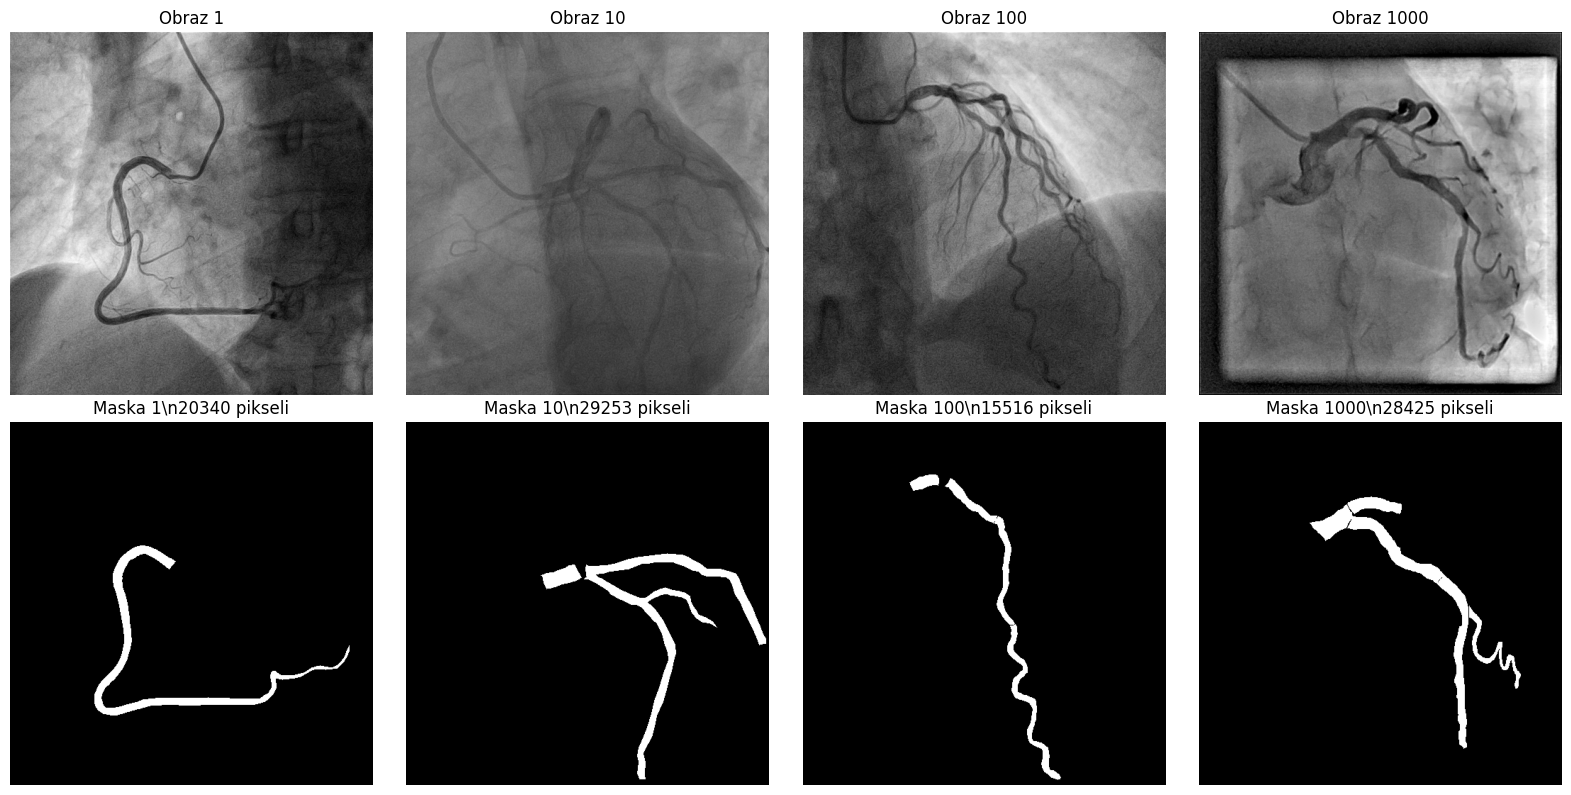

In [1]:
# 1. IMPORTY I KONFIGURACJA
import os
import glob
import torch
import numpy as np
import time
import copy
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
# PyTorch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# Augmentacje i preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# MONAI dla zaawansowanych funkcji straty
# from monai.losses import DiceLoss as MonaiDice, FocalLoss as MonaiFocal, TverskyLoss as MonaiTversky, DiceCELoss as MonaiDiceCE, DiceFocalLoss as MonaiDiceFocal

# Sprawdzenie dostępności GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'PyTorch używa GPU: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("PyTorch używa MPS (Metal Performance Shaders)")
else:
    device = torch.device("cpu")
    print("GPU niedostępne, używamy CPU")

print(f"🔧 Device: {device}")
path = '/home/ives/rafal/notebooks/data'

# 2. ANALIZA DATASETU
def analyze_dataset(data_path=path):
    """Analiza struktury i właściwości datasetu"""

    imgs_path = os.path.join(data_path, "imgs")
    masks_path = os.path.join(data_path, "masks")

    # Znajdź wszystkie pliki
    img_files = sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))
    mask_files = sorted(glob.glob(os.path.join(masks_path, "*.png")))

    print(f"Ścieżka danych: {data_path}")
    print(f"Znaleziono {len(img_files)} obrazów (.jpg)")
    print(f"Znaleziono {len(mask_files)} masek (.png)")

    # Sprawdź czy nazwy się zgadzają
    img_names = {os.path.splitext(os.path.basename(f))[0] for f in img_files}
    mask_names = {os.path.splitext(os.path.basename(f))[0] for f in mask_files}

    common_names = img_names.intersection(mask_names)
    print(f"{len(common_names)} par obraz-maska")

    if len(img_names - mask_names) > 0:
        print(f"{len(img_names - mask_names)} obrazów bez masek")
    if len(mask_names - img_names) > 0:
        print(f"{len(mask_names - img_names)} masek bez obrazów")

    # Analiza próbek
    print(f"\\nANALIZA PRÓBEK:")
    sample_names = sorted(list(common_names))[:5]  # Pierwsze 5 próbek

    for i, name in enumerate(sample_names):
        img_path = os.path.join(imgs_path, f"{name}.jpg")
        mask_path = os.path.join(masks_path, f"{name}.png")

        # Załaduj obraz
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        # Konwertuj do numpy dla analizy
        img_np = np.array(img)
        mask_np = np.array(mask)

        print(f"\\n--- PRÓBKA {name} ---")
        print(f"Obraz: {img_np.shape}, dtype: {img_np.dtype}")
        print(f"  Min: {img_np.min()}, Max: {img_np.max()}, Mean: {img_np.mean():.2f}")

        print(f"Maska: {mask_np.shape}, dtype: {mask_np.dtype}")
        print(f"  Min: {mask_np.min()}, Max: {mask_np.max()}")
        print(f"  Unikalne wartości: {np.unique(mask_np)}")
        print(f"  Piksele pozytywne: {(mask_np > 0).sum()}/{mask_np.size} ({(mask_np > 0).mean()*100:.2f}%)")

    # Sprawdź czy obrazy są grayscale
    sample_img = Image.open(os.path.join(imgs_path, f"{sample_names[0]}.jpg"))
    sample_np = np.array(sample_img)

    is_grayscale = len(sample_np.shape) == 2 or (len(sample_np.shape) == 3 and sample_np.shape[2] == 1)
    if len(sample_np.shape) == 3 and sample_np.shape[2] == 3:
        # Sprawdź czy wszystkie kanały są identyczne (pseudo-grayscale)
        r, g, b = sample_np[:,:,0], sample_np[:,:,1], sample_np[:,:,2]
        is_grayscale = np.array_equal(r, g) and np.array_equal(g, b)

    print(f"\\nKOLORY:")
    print(f"Obrazy są grayscale: {'TAK' if is_grayscale else 'NIE'}")

    return {
        'img_files': img_files,
        'mask_files': mask_files,
        'common_names': sorted(list(common_names)),
        'is_grayscale': is_grayscale,
        'sample_shape': sample_np.shape
    }

# Uruchom analizę
dataset_info = analyze_dataset()

# 3. WIZUALIZACJA PRÓBEK
def visualize_samples(dataset_info, num_samples=4):
    """Wizualizacja próbek z datasetu"""

    data_path = path
    imgs_path = os.path.join(data_path, "imgs")
    masks_path = os.path.join(data_path, "masks")

    sample_names = dataset_info['common_names'][:num_samples]

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*4, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    for i, name in enumerate(sample_names):
        # Załaduj obraz i maskę
        img = Image.open(os.path.join(imgs_path, f"{name}.jpg"))
        mask = Image.open(os.path.join(masks_path, f"{name}.png"))

        # Konwertuj do numpy
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Wyświetl obraz
        axes[0, i].imshow(img_np, cmap='gray' if dataset_info['is_grayscale'] else None)
        axes[0, i].set_title(f'Obraz {name}')
        axes[0, i].axis('off')

        # Wyświetl maskę
        axes[1, i].imshow(mask_np, cmap='gray')
        axes[1, i].set_title(f'Maska {name}\\n{(mask_np > 0).sum()} pikseli')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Wyświetl próbki
visualize_samples(dataset_info)



In [2]:
# 4. ARCHITEKTURY MODELI
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional

# ======================= PODSTAWOWE BLOKI =======================

class ResidualBlock(nn.Module):
    """Ulepszona wersja bloku residualnego z opcjonalnym dropout i aktywacją"""
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0, activation='relu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        # Wybór funkcji aktywacji
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'leaky_relu':
            self.activation = F.leaky_relu
        elif activation == 'elu':
            self.activation = F.elu
        else:
            self.activation = F.relu
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual
        return self.activation(out)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionGate(nn.Module):
    """Attention Gate dla precyzyjnego łączenia feature map"""
    def __init__(self, in_channels, gating_channels, inter_channels):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, 1, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 1, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, 1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# ======================= MODEL 0: Simple ResUNet (Baseline) =======================

class SimpleResUNet(nn.Module):
    """Stabilna wersja oryginalnego ResUNet z poprawionymi wymiarami"""
    def __init__(self, n_class=1, base_channels=64):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(base_channels, base_channels, 2)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 2, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 2, stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, 2, stride=2)
        
        # Decoder
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 2)
        
        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 2)
        
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 2)
        
        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 2)
        
        self.final = nn.Conv2d(base_channels, n_class, 1)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        conv1 = x
        x = self.maxpool(x)
        
        conv2 = self.layer1(x)
        conv3 = self.layer2(conv2)
        conv4 = self.layer3(conv3)
        x = self.layer4(conv4)
        
        # Decoder
        x = self.up4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dec4(x)
        
        x = self.up3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec3(x)
        
        x = self.up2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec1(x)
        
        return self.final(x)

# ======================= MODEL 1: ResUNet++ (Średni) =======================

class ResUNetPlusPlus(nn.Module):
    """ResUNet++ - ulepszona wersja z nested skip connections"""
    def __init__(self, n_class=1, base_channels=64, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        
        # Encoder
        self.conv0_0 = self._make_layer(1, base_channels, 2)
        self.conv1_0 = self._make_layer(base_channels, base_channels * 2, 2, stride=2)
        self.conv2_0 = self._make_layer(base_channels * 2, base_channels * 4, 2, stride=2)
        self.conv3_0 = self._make_layer(base_channels * 4, base_channels * 8, 2, stride=2)
        self.conv4_0 = self._make_layer(base_channels * 8, base_channels * 16, 2, stride=2)
        
        # Nested skip pathways
        self.conv0_1 = self._make_layer(base_channels + base_channels * 2, base_channels, 2)
        self.conv1_1 = self._make_layer(base_channels * 2 + base_channels * 4, base_channels * 2, 2)
        self.conv2_1 = self._make_layer(base_channels * 4 + base_channels * 8, base_channels * 4, 2)
        self.conv3_1 = self._make_layer(base_channels * 8 + base_channels * 16, base_channels * 8, 2)
        
        self.conv0_2 = self._make_layer(base_channels * 2 + base_channels * 2, base_channels, 2)
        self.conv1_2 = self._make_layer(base_channels * 4 + base_channels * 4, base_channels * 2, 2)
        self.conv2_2 = self._make_layer(base_channels * 8 + base_channels * 8, base_channels * 4, 2)
        
        self.conv0_3 = self._make_layer(base_channels * 3 + base_channels * 2, base_channels, 2)
        self.conv1_3 = self._make_layer(base_channels * 6 + base_channels * 4, base_channels * 2, 2)
        
        self.conv0_4 = self._make_layer(base_channels * 4 + base_channels * 2, base_channels, 2)
        
        # Upsampling layers
        self.up1_0 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(base_channels * 8, base_channels * 8, 2, stride=2)
        self.up4_0 = nn.ConvTranspose2d(base_channels * 16, base_channels * 16, 2, stride=2)
        
        # Additional upsampling for nested paths
        self.up1_1 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 2, stride=2)
        self.up3_1 = nn.ConvTranspose2d(base_channels * 8, base_channels * 8, 2, stride=2)
        
        self.up1_2 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        self.up2_2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 2, stride=2)
        
        self.up1_3 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        
        # Final layers
        if deep_supervision:
            self.final1 = nn.Conv2d(base_channels, n_class, 1)
            self.final2 = nn.Conv2d(base_channels, n_class, 1)
            self.final3 = nn.Conv2d(base_channels, n_class, 1)
            self.final4 = nn.Conv2d(base_channels, n_class, 1)
        else:
            self.final = nn.Conv2d(base_channels, n_class, 1)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder path
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(x0_0)
        x2_0 = self.conv2_0(x1_0)
        x3_0 = self.conv3_0(x2_0)
        x4_0 = self.conv4_0(x3_0)
        
        # Nested skip connections - Level 1
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4_0(x4_0)], 1))
        
        # Nested skip connections - Level 2
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1_1(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2_1(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3_1(x3_1)], 1))
        
        # Nested skip connections - Level 3
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1_2(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2_2(x2_2)], 1))
        
        # Final level
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1_3(x1_3)], 1))
        
        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            return self.final(x0_4)

# ======================= MODEL 2: Attention ResUNet (Duży) =======================

class AttentionResUNet(nn.Module):
    """ResUNet z Attention Gates i SE blocks"""
    def __init__(self, n_class=1, base_channels=64, use_se=True, dropout_p=0.1):
        super().__init__()
        self.use_se = use_se
        
        # Encoder - POPRAWIONE WYMIARY
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(base_channels, base_channels, 3)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 4, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 6, stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, 3, stride=2)
        
        # SE blocks
        if use_se:
            self.se1 = SEBlock(base_channels)
            self.se2 = SEBlock(base_channels * 2)
            self.se3 = SEBlock(base_channels * 4)
            self.se4 = SEBlock(base_channels * 8)
        
        # Attention Gates - POPRAWIONE WYMIARY
        self.att4 = AttentionGate(base_channels * 4, base_channels * 4, base_channels * 2)
        self.att3 = AttentionGate(base_channels * 2, base_channels * 2, base_channels)
        self.att2 = AttentionGate(base_channels, base_channels, base_channels // 2)
        self.att1 = AttentionGate(base_channels, base_channels, base_channels // 2)
        
        # Decoder - POPRAWIONE WYMIARY
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 3)
        
        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 3)
        
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 3)
        
        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 2)
        
        self.final = nn.Conv2d(base_channels, n_class, 1)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride, dropout=0.1)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, dropout=0.1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        conv1 = x
        x = self.maxpool(x)
        
        conv2 = self.layer1(x)
        if self.use_se: conv2 = self.se1(conv2)
        
        conv3 = self.layer2(conv2)
        if self.use_se: conv3 = self.se2(conv3)
        
        conv4 = self.layer3(conv3)
        if self.use_se: conv4 = self.se3(conv4)
        
        x = self.layer4(conv4)
        if self.use_se: x = self.se4(x)
        
        # Decoder with attention - POPRAWIONE
        x = self.up4(x)
        conv4_att = self.att4(conv4, x)
        x = torch.cat([x, conv4_att], dim=1)
        x = self.dec4(x)
        
        x = self.up3(x)
        conv3_att = self.att3(conv3, x)
        x = torch.cat([x, conv3_att], dim=1)
        x = self.dec3(x)
        
        x = self.up2(x)
        conv2_att = self.att2(conv2, x)
        x = torch.cat([x, conv2_att], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)
        conv1_att = self.att1(conv1, x)
        x = torch.cat([x, conv1_att], dim=1)
        x = self.dec1(x)
        
        return self.final(x)

# ======================= MODEL 3: Deep ResUNet (Bardzo duży) =======================

class DeepResUNet(nn.Module):
    """Bardzo głęboki ResUNet inspirowany ResNet-152"""
    def __init__(self, n_class=1, base_channels=64, layers=[3, 8, 36, 3]):
        super().__init__()
        
        # Initial conv - BEZ stride=2, żeby zachować wymiary
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Encoder layers
        self.layer1 = self._make_layer(base_channels, base_channels, layers[0])
        self.layer2 = self._make_layer(base_channels, base_channels * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, layers[3], stride=2)
        
        # Bridge with dilated convolutions
        self.bridge = nn.Sequential(
            nn.Conv2d(base_channels * 8, base_channels * 16, 3, padding=2, dilation=2),
            nn.BatchNorm2d(base_channels * 16),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 16, base_channels * 16, 3, padding=4, dilation=4),
            nn.BatchNorm2d(base_channels * 16),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 16, base_channels * 8, 3, padding=2, dilation=2),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(inplace=True)
        )
        
        # Decoder with more layers
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 6)
        
        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 8)
        
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 4)
        
        # POPRAWIONE - upsampling do oryginalnego rozmiaru
        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 3)
        
        # Final conv bez dodatkowego upsamplingu
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels // 2, 3, padding=1),
            nn.BatchNorm2d(base_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels // 2, n_class, 1)
        )
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride, dropout=0.1, activation='leaky_relu')]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, dropout=0.1, activation='leaky_relu'))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder - zapisujemy feature mapy dla skip connections
        original_size = x.shape[2:]  # Zapisz oryginalny rozmiar
        
        x = F.relu(self.bn1(self.conv1(x)))
        conv0 = x  # 512x512
        x = self.maxpool(x)
        
        conv1 = self.layer1(x)  # 256x256
        conv2 = self.layer2(conv1)  # 128x128  
        conv3 = self.layer3(conv2)  # 64x64
        conv4 = self.layer4(conv3)  # 32x32
        
        # Bridge
        x = self.bridge(conv4)  # 32x32
        
        # Decoder z prawidłowymi wymiarami
        x = self.up4(x)  # 64x64
        x = torch.cat([x, conv3], dim=1)
        x = self.dec4(x)
        
        x = self.up3(x)  # 128x128
        x = torch.cat([x, conv2], dim=1) 
        x = self.dec3(x)
        
        x = self.up2(x)  # 256x256
        x = torch.cat([x, conv1], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)  # 512x512
        x = torch.cat([x, conv0], dim=1)
        x = self.dec1(x)
        
        return self.final_conv(x)

# ======================= FUNKCJE POMOCNICZE =======================

def count_parameters(model):
    """Liczy parametry modelu"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_info(model, input_size=(1, 1, 512, 512)):
    """Zwraca informacje o modelu"""
    total_params = count_parameters(model)
    
    # Test forward pass
    model.eval()
    with torch.no_grad():
        x = torch.randn(input_size)
        try:
            output = model(x)
            if isinstance(output, list):
                output_shape = [o.shape for o in output]
            else:
                output_shape = output.shape
        except Exception as e:
            output_shape = f"Error: {e}"
    
    return {
        'parameters': total_params,
        'parameters_M': total_params / 1e6,
        'output_shape': output_shape
    }

# def create_model(model_type='resunet++', **kwargs):
#     """Factory function do tworzenia modeli"""
#     models = {
#         'resunet++': ResUNetPlusPlus,
#         'attention_resunet': AttentionResUNet,
#         'deep_resunet': DeepResUNet
#     }
    
#     if model_type not in models:
#         raise ValueError(f"Unknown model type: {model_type}. Available: {list(models.keys())}")
    
#     return models[model_type](**kwargs)

# # ======================= PRZYKŁADY UŻYCIA =======================

# if __name__ == "__main__":
#     print("🏗️  PORÓWNANIE MODELI ResUNet")
#     print("=" * 50)
    
#     models_config = [
#         ('Original ResUNet (baseline)', 'simple_resunet', {'base_channels': 64}),
#         ('ResUNet++', 'resunet++', {'base_channels': 64}),
#         ('Attention ResUNet', 'attention_resunet', {'base_channels': 64}),
#         ('Deep ResUNet', 'deep_resunet', {'base_channels': 64}),
#         ('Large Deep ResUNet', 'deep_resunet', {'base_channels': 96, 'layers': [3, 12, 48, 3]}),
#     ]
    
#     for name, model_type, config in models_config:
#         try:
#             model = create_model(model_type, **config)
#             info = get_model_info(model)
            
#             print(f"\n📊 {name}:")
#             print(f"   Parameters: {info['parameters_M']:.2f}M ({info['parameters']:,})")
#             print(f"   Output shape: {info['output_shape']}")
            
#         except Exception as e:
#             print(f"\n❌ {name}: Error - {e}")
    
#     print("\n" + "=" * 50)
#     print("💡 Wszystkie modele gotowe do użycia!")

def double_conv(in_channels, out_channels):
    """Standardowy blok podwójnej konwolucji"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

def enhanced_double_conv(in_channels, out_channels, dropout_p=0.1):
    """Rozszerzony blok z batch normalization i dropout"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(dropout_p),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(dropout_p)
    )

# Original UNet
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Encoder
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Decoder
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

# Enhanced UNet z większą liczbą parametrów
class EnhancedUNet(nn.Module):
    def __init__(self, n_class=1, dropout_p=0.1, base_channels=64):
        super().__init__()

        # Encoder (5 poziomów)
        self.dconv_down1 = enhanced_double_conv(1, base_channels, dropout_p)
        self.dconv_down2 = enhanced_double_conv(base_channels, base_channels * 2, dropout_p)
        self.dconv_down3 = enhanced_double_conv(base_channels * 2, base_channels * 4, dropout_p)
        self.dconv_down4 = enhanced_double_conv(base_channels * 4, base_channels * 8, dropout_p)
        self.dconv_down5 = enhanced_double_conv(base_channels * 8, base_channels * 16, dropout_p)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Decoder
        self.dconv_up4 = enhanced_double_conv(base_channels * 8 + base_channels * 16, base_channels * 8, dropout_p)
        self.dconv_up3 = enhanced_double_conv(base_channels * 4 + base_channels * 8, base_channels * 4, dropout_p)
        self.dconv_up2 = enhanced_double_conv(base_channels * 2 + base_channels * 4, base_channels * 2, dropout_p)
        self.dconv_up1 = enhanced_double_conv(base_channels + base_channels * 2, base_channels, dropout_p)

        self.conv_last = nn.Conv2d(base_channels, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

# Residual blocks dla ResUNet
class ResidualBlock2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class ResUNet(nn.Module):
    def __init__(self, n_class=1, base_channels=64):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(base_channels, base_channels, 2)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 2, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 2, stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, 2, stride=2)

        # Decoder
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 2)

        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 2)

        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 2)

        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 2)

        self.final = nn.Conv2d(base_channels, n_class, 1)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock2(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock2(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        conv1 = x
        x = self.maxpool(x)

        conv2 = self.layer1(x)
        conv3 = self.layer2(conv2)
        conv4 = self.layer3(conv3)
        x = self.layer4(conv4)

        # Decoder
        x = self.up4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dec4(x)

        x = self.up3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec1(x)

        return self.final(x)

# Funkcja do tworzenia modeli
def create_model(model_type='unet', n_class=1):
    """Factory function dla tworzenia modeli"""
    if model_type == 'unet':
        return UNet(n_class)
    elif model_type == 'enhanced_unet':
        return EnhancedUNet(n_class, dropout_p=0.1, base_channels=64)
    elif model_type == 'resunet' or model_type == 'ResUNet':
        return ResUNet(n_class, base_channels=64)
    elif model_type == 'resunetpp':
        return ResUNetPlusPlus(n_class)
    elif model_type == 'attention_resunet':
        return AttentionResUNet(n_class, dropout_p=0.1, base_channels=64)
    elif model_type == 'deep_resunet':
        return DeepResUNet(n_class, base_channels=64)
    else:
        raise ValueError(f"Nieznany typ modelu: {model_type}")

# Porównanie liczby parametrów
def compare_model_sizes():
    """Porównanie rozmiarów modeli"""
    models = {
        'UNet': UNet(1),
        'Enhanced UNet': EnhancedUNet(1),
        'ResUNet': ResUNet(1),
        'ResUNetPP': ResUNetPlusPlus(1),
        'AttentionResUNet': AttentionResUNet(1),
        'DeepResUNet': DeepResUNet(1)
    }

    print("📊 PORÓWNANIE MODELI:")
    print("-" * 40)

    for name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"{name:15}: {total_params:,} parametrów ({trainable_params:,} trenowalnych)")

    return models

# Porównaj modele
model_comparison = compare_model_sizes()


📊 PORÓWNANIE MODELI:
----------------------------------------
UNet           : 7,781,761 parametrów (7,781,761 trenowalnych)
Enhanced UNet  : 31,389,569 parametrów (31,389,569 trenowalnych)
ResUNet        : 16,115,713 parametrów (16,115,713 trenowalnych)
ResUNetPP      : 79,597,121 parametrów (79,597,121 trenowalnych)
AttentionResUNet: 27,909,389 parametrów (27,909,389 trenowalnych)
DeepResUNet    : 88,443,457 parametrów (88,443,457 trenowalnych)


In [3]:
# # 6. FUNKCJE STRATY

# from abc import ABC, abstractmethod

# class LossFunction(ABC):
#     @abstractmethod
#     def compute(self, pred, target):
#         pass

# # Podstawowe funkcje straty
# class DiceLoss(LossFunction):
#     def compute(self, pred, target, smooth=1e-5):
#         pred = pred.contiguous()
#         target = target.contiguous()
#         intersection = (pred * target).sum(dim=2).sum(dim=2)
#         loss = (1 - ((2. * intersection + smooth) /
#                     (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
#         return loss.mean()

# class IoULoss(LossFunction):
#     def compute(self, pred, target, smooth=1e-5):
#         intersection = (pred * target).sum()
#         union = pred.sum() + target.sum() - intersection
#         iou = (intersection + smooth) / (union + smooth)
#         return 1 - iou

# # MONAI Loss Functions - POPRAWIONE
# class MonaiDiceLoss(LossFunction):
#     def __init__(self, include_background=False, sigmoid=True, smooth_nr=1e-5, smooth_dr=1e-5):
#         # include_background=False dla segmentacji tętnic (foreground)
#         self.dice_loss = MonaiDice(
#             include_background=include_background,
#             sigmoid=sigmoid,
#             smooth_nr=smooth_nr,
#             smooth_dr=smooth_dr
#         )

#     def compute(self, pred, target):
#         # Sprawdź czy maski mają pozytywne piksele
#         if target.sum() == 0:
#             print("WARNING: Wszystkie maski są zerowe!")
#             return torch.tensor(1.0, device=pred.device)
#         return self.dice_loss(pred, target)

# class MonaiFocalLoss(LossFunction):
#     def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
#         self.focal_loss = MonaiFocal(alpha=alpha, gamma=gamma, reduction=reduction)

#     def compute(self, pred, target):
#         return self.focal_loss(pred, target)

# class MonaiTverskyLoss(LossFunction):
#     def __init__(self, alpha=0.5, beta=0.5, sigmoid=True):
#         self.tversky_loss = MonaiTversky(alpha=alpha, beta=beta, sigmoid=sigmoid)

#     def compute(self, pred, target):
#         return self.tversky_loss(pred, target)

# class MonaiDiceCELoss(LossFunction):
#     def __init__(self, sigmoid=True, lambda_dice=1.0, lambda_ce=1.0):
#         self.dice_ce_loss = MonaiDiceCE(sigmoid=sigmoid, lambda_dice=lambda_dice, lambda_ce=lambda_ce)

#     def compute(self, pred, target):
#         return self.dice_ce_loss(pred, target)

# class MonaiDiceFocalLoss(LossFunction):
#     def __init__(self, sigmoid=True, lambda_dice=1.0, lambda_focal=1.0, alpha=0.25, gamma=2.0):
#         self.dice_focal_loss = MonaiDiceFocal(
#             sigmoid=sigmoid,
#             lambda_dice=lambda_dice,
#             lambda_focal=lambda_focal,
#             alpha=alpha,
#             gamma=gamma
#         )

#     def compute(self, pred, target):
#         return self.dice_focal_loss(pred, target)

# class CombinedLoss(LossFunction):
#     def __init__(self, loss_functions_weights):
#         """
#         loss_functions_weights: dict of {loss_function_instance: weight}
#         """
#         self.loss_functions_weights = loss_functions_weights

#     def compute(self, pred, target):
#         total_loss = 0
#         for loss_fn, weight in self.loss_functions_weights.items():
#             total_loss += weight * loss_fn.compute(pred, target)
#         return total_loss

# # Funkcja do obliczania łącznej straty
# def calculate_loss(pred, target, metrics, bce_weight=0.1, loss_function=None):
#     """Oblicza łączną stratę BCE + funkcja straty"""

#     if loss_function is None:
#         loss_function = DiceLoss()

#     # BCE Loss
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     # Zastosuj sigmoid dla funkcji straty
#     pred_sigmoid = torch.sigmoid(pred)

#     # Oblicz stratę z wybranej funkcji
#     custom_loss = loss_function.compute(pred_sigmoid, target)

#     # Łączna strata
#     total_loss = bce * bce_weight + custom_loss * (1 - bce_weight)

#     # Aktualizuj metryki
#     loss_name = loss_function.__class__.__name__.lower().replace('loss', '')
#     with torch.no_grad():
#         metrics['bce'] += bce.item() * target.size(0)
#         metrics[loss_name] += custom_loss.item() * target.size(0)
#         metrics['total_loss'] += total_loss.item() * target.size(0)

#     return total_loss

# # Dostępne funkcje straty
# def get_loss_functions():
#     """Zwraca mapowanie dostępnych funkcji straty"""
#     return {
#         'dice': DiceLoss(),
#         'iou': IoULoss(),
#         'monai_dice': MonaiDiceLoss(include_background=False, sigmoid=True),
#         'monai_focal': MonaiFocalLoss(),
#         'monai_tversky': MonaiTverskyLoss(),
#         'monai_dice_ce': MonaiDiceCELoss(),
#         'monai_dice_focal': MonaiDiceFocalLoss(),
#         'combined': CombinedLoss({
#             MonaiDiceLoss(include_background=False): 0.6,
#             MonaiFocalLoss(): 0.4
#         })
#     }

# # Wyświetl dostępne funkcje straty
# print("DOSTĘPNE FUNKCJE STRATY:")
# loss_functions = get_loss_functions()
# for name, loss_fn in loss_functions.items():
#     print(f"  - '{name}': {loss_fn.__class__.__name__}")

# # Test funkcji straty na przykładowych danych
# def test_loss_functions():
#     """Test wszystkich funkcji straty"""
#     print("\\nTEST FUNKCJI STRATY:")

#     # Stwórz przykładowe dane
#     batch_size = 2
#     pred = torch.randn(batch_size, 1, 64, 64, device=device)
#     target = torch.randint(0, 2, (batch_size, 1, 64, 64), device=device).float()

#     print(f"Test data - Pred: {pred.shape}, Target: {target.shape}")
#     print(f"Target positive pixels: {target.sum().item()}")

#     for name, loss_fn in loss_functions.items():
#         try:
#             pred_sigmoid = torch.sigmoid(pred)
#             loss_value = loss_fn.compute(pred_sigmoid, target)
#             print(f"  {name:15}: {loss_value:.6f}")
#         except Exception as e:
#             print(f"  {name:15}: ERROR - {str(e)}")

# test_loss_functions()

# 6. FUNKCJE STRATY - IMPLEMENTACJA BEZ MONAI

import torch
import torch.nn as nn
import torch.nn.functional as F
from abc import ABC, abstractmethod

class LossFunction(ABC):
    @abstractmethod
    def compute(self, pred, target):
        pass

# Podstawowe funkcje straty
class DiceLoss(LossFunction):
    def __init__(self, smooth=1e-5):
        self.smooth = smooth
    
    def compute(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()
        intersection = (pred * target).sum(dim=2).sum(dim=2)
        loss = (1 - ((2. * intersection + self.smooth) /
                    (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + self.smooth)))
        return loss.mean()

class IoULoss(LossFunction):
    def __init__(self, smooth=1e-5):
        self.smooth = smooth
    
    def compute(self, pred, target):
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou

# Manualne implementacje funkcji straty (bez MONAI)
class FocalLoss(LossFunction):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def compute(self, pred, target):
        """
        Focal Loss dla segmentacji binarnej
        pred: (N, C, H, W) - logits lub prawdopodobieństwa
        target: (N, C, H, W) - binarne maski
        """
        # Sprawdź czy pred to prawdopodobieństwa czy logits
        if pred.min() < 0 or pred.max() > 1:
            # Jeśli to logits, zastosuj sigmoid
            pred = torch.sigmoid(pred)
        
        # Oblicz BCE dla każdego piksela
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        
        # p_t - prawdopodobieństwo dla prawidłowej klasy
        p_t = pred * target + (1 - pred) * (1 - target)
        
        # alpha_t - waga dla prawidłowej klasy
        alpha_t = self.alpha * target + (1 - self.alpha) * (1 - target)
        
        # Focal Loss
        focal_loss = alpha_t * (1 - p_t) ** self.gamma * bce
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class TverskyLoss(LossFunction):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-5):
        """
        Tversky Loss
        alpha: waga dla False Positives
        beta: waga dla False Negatives
        Gdy alpha=beta=0.5, odpowiada Dice Loss
        """
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
    
    def compute(self, pred, target):
        # Sprawdź czy pred to prawdopodobieństwa czy logits
        if pred.min() < 0 or pred.max() > 1:
            pred = torch.sigmoid(pred)
        
        # Flatten tensors
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        # True Positives, False Positives, False Negatives
        TP = (pred_flat * target_flat).sum()
        FP = ((1 - target_flat) * pred_flat).sum()
        FN = (target_flat * (1 - pred_flat)).sum()
        
        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        
        return 1 - tversky

class DiceCELoss(LossFunction):
    def __init__(self, lambda_dice=1.0, lambda_ce=1.0, smooth=1e-5):
        """
        Kombinacja Dice Loss + Cross Entropy Loss
        """
        self.lambda_dice = lambda_dice
        self.lambda_ce = lambda_ce
        self.dice_loss = DiceLoss(smooth=smooth)
    
    def compute(self, pred, target):
        # Dice Loss (wymaga prawdopodobieństw)
        if pred.min() < 0 or pred.max() > 1:
            pred_prob = torch.sigmoid(pred)
            dice_loss = self.dice_loss.compute(pred_prob, target)
            # CE Loss (wymaga logits)
            ce_loss = F.binary_cross_entropy_with_logits(pred, target)
        else:
            # pred to już prawdopodobieństwa
            dice_loss = self.dice_loss.compute(pred, target)
            # Konwertuj do logits dla CE
            pred_logits = torch.log(pred / (1 - pred + 1e-8))
            ce_loss = F.binary_cross_entropy_with_logits(pred_logits, target)
        
        return self.lambda_dice * dice_loss + self.lambda_ce * ce_loss

class DiceFocalLoss(LossFunction):
    def __init__(self, lambda_dice=1.0, lambda_focal=1.0, alpha=0.25, gamma=2.0, smooth=1e-5):
        """
        Kombinacja Dice Loss + Focal Loss
        """
        self.lambda_dice = lambda_dice
        self.lambda_focal = lambda_focal
        self.dice_loss = DiceLoss(smooth=smooth)
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
    
    def compute(self, pred, target):
        # Sprawdź czy pred to prawdopodobieństwa czy logits
        if pred.min() < 0 or pred.max() > 1:
            pred_prob = torch.sigmoid(pred)
        else:
            pred_prob = pred
        
        dice_loss = self.dice_loss.compute(pred_prob, target)
        focal_loss = self.focal_loss.compute(pred_prob, target)
        
        return self.lambda_dice * dice_loss + self.lambda_focal * focal_loss

class CombinedLoss(LossFunction):
    def __init__(self, loss_functions_weights):
        """
        loss_functions_weights: dict of {loss_function_instance: weight}
        """
        self.loss_functions_weights = loss_functions_weights

    def compute(self, pred, target):
        total_loss = 0
        for loss_fn, weight in self.loss_functions_weights.items():
            total_loss += weight * loss_fn.compute(pred, target)
        return total_loss

# Dodatkowe funkcje straty
class LogCoshDiceLoss(LossFunction):
    def __init__(self, smooth=1e-5):
        """
        Log-Cosh Dice Loss - łagodniejsza wersja Dice Loss
        """
        self.smooth = smooth
    
    def compute(self, pred, target):
        if pred.min() < 0 or pred.max() > 1:
            pred = torch.sigmoid(pred)
        
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        
        return torch.log(torch.cosh(1 - dice))

class ComboLoss(LossFunction):
    def __init__(self, alpha=0.5, ce_ratio=0.5, smooth=1e-5):
        """
        Combo Loss = alpha * BCE + (1-alpha) * Dice
        """
        self.alpha = alpha
        self.ce_ratio = ce_ratio
        self.smooth = smooth
    
    def compute(self, pred, target):
        # BCE component
        if pred.min() < 0 or pred.max() > 1:
            bce = F.binary_cross_entropy_with_logits(pred, target)
            pred_prob = torch.sigmoid(pred)
        else:
            bce = F.binary_cross_entropy(pred, target)
            pred_prob = pred
        
        # Dice component
        pred_flat = pred_prob.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        dice_loss = 1 - dice
        
        return self.alpha * bce + (1 - self.alpha) * dice_loss

# Funkcja do obliczania łącznej straty
def calculate_loss(pred, target, metrics, bce_weight=0.3, loss_function=None):
    """Oblicza łączną stratę BCE + funkcja straty"""

    if loss_function is None:
        loss_function = DiceLoss()

    # BCE Loss
    bce = F.binary_cross_entropy_with_logits(pred, target)

    # Zastosuj sigmoid dla funkcji straty
    pred_sigmoid = torch.sigmoid(pred)

    # Oblicz stratę z wybranej funkcji
    custom_loss = loss_function.compute(pred_sigmoid, target)

    # Łączna strata
    total_loss = bce * bce_weight + custom_loss * (1 - bce_weight)

    # Aktualizuj metryki
    loss_name = loss_function.__class__.__name__.lower().replace('loss', '')
    with torch.no_grad():
        metrics['bce'] += bce.item() * target.size(0)
        metrics[loss_name] += custom_loss.item() * target.size(0)
        metrics['total_loss'] += total_loss.item() * target.size(0)

    return total_loss

# Dostępne funkcje straty
def get_loss_functions():
    """Zwraca mapowanie dostępnych funkcji straty"""
    return {
        'dice': DiceLoss(),
        'iou': IoULoss(),
        'focal': FocalLoss(),
        'tversky': TverskyLoss(),
        'dice_ce': DiceCELoss(),
        'dice_focal': DiceFocalLoss(),
        'log_cosh_dice': LogCoshDiceLoss(),
        'combo': ComboLoss(),
        'combined': CombinedLoss({
            DiceLoss(): 0.6,
            FocalLoss(): 0.4
        })
    }

# Test funkcji straty na przykładowych danych
def test_loss_functions(device='cpu'):
    """Test wszystkich funkcji straty"""
    print("\nTEST FUNKCJI STRATY:")
    
    # Wyświetl dostępne funkcje straty
    print("\nDOSTĘPNE FUNKCJE STRATY:")
    loss_functions = get_loss_functions()
    for name, loss_fn in loss_functions.items():
        print(f"  - '{name}': {loss_fn.__class__.__name__}")

    # Stwórz przykładowe dane
    batch_size = 2
    pred = torch.randn(batch_size, 1, 64, 64, device=device)
    target = torch.randint(0, 2, (batch_size, 1, 64, 64), device=device).float()

    print(f"\nTest data - Pred: {pred.shape}, Target: {target.shape}")
    print(f"Target positive pixels: {target.sum().item()}")
    print(f"Pred range: [{pred.min():.3f}, {pred.max():.3f}]")

    print("\nWYNIKI TESTÓW:")
    for name, loss_fn in loss_functions.items():
        try:
            # Test z logits (surowe wyjście sieci)
            loss_value_logits = loss_fn.compute(pred, target)
            
            # Test z prawdopodobieństwami
            pred_sigmoid = torch.sigmoid(pred)
            loss_value_prob = loss_fn.compute(pred_sigmoid, target)
            
            print(f"  {name:15}: logits={loss_value_logits:.6f}, prob={loss_value_prob:.6f}")
        except Exception as e:
            print(f"  {name:15}: ERROR - {str(e)}")

# Uruchom test jeśli plik jest wykonywany bezpośrednio

    
test_loss_functions(device)



TEST FUNKCJI STRATY:

DOSTĘPNE FUNKCJE STRATY:
  - 'dice': DiceLoss
  - 'iou': IoULoss
  - 'focal': FocalLoss
  - 'tversky': TverskyLoss
  - 'dice_ce': DiceCELoss
  - 'dice_focal': DiceFocalLoss
  - 'log_cosh_dice': LogCoshDiceLoss
  - 'combo': ComboLoss
  - 'combined': CombinedLoss

Test data - Pred: torch.Size([2, 1, 64, 64]), Target: torch.Size([2, 1, 64, 64])
Target positive pixels: 4088.0
Pred range: [-4.528, 3.462]

WYNIKI TESTÓW:
  dice           : logits=0.977353, prob=0.497361
  iou            : logits=0.988512, prob=0.664307
  focal          : logits=0.168270, prob=0.168270
  tversky        : logits=0.497350, prob=0.497350
  dice_ce        : logits=1.293826, prob=1.293826
  dice_focal     : logits=0.665631, prob=0.665631
  log_cosh_dice  : logits=0.118893, prob=0.118893
  combo          : logits=0.646907, prob=0.646907
  combined       : logits=0.653720, prob=0.365725


In [4]:
# 7. TRENING MODELU

def print_metrics(metrics, epoch_samples, phase):
    """Wydrukuj metryki"""
    outputs = [f"{k}: {metrics[k] / epoch_samples:.4f}" for k in metrics.keys()]
    print(f"{phase}: {', '.join(outputs)}")


def train_model(model, dataloaders, optimizer, scheduler, loss_function_name='dice',
                bce_weight=0.1, num_epochs=10, save_path='best_model.pth'):
    """
    Główna funkcja treningu modelu
    """

    model = model.to(device)

    # Pobierz funkcję straty
    loss_functions = get_loss_functions()
    if loss_function_name not in loss_functions:
        print(f"Nieznana funkcja straty: {loss_function_name}, używam 'dice'")
        loss_function_name = 'dice'

    loss_function = loss_functions[loss_function_name]
    print(f"🎯 Funkcja straty: {loss_function_name}")

    writer = SummaryWriter(comment=f'_{loss_function_name}_epochs_{num_epochs}_bce_{bce_weight}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    history = {'train_loss': [], 'val_loss': []}

    print(f"🚀 Rozpoczynam trening na {num_epochs} epok...")
    print(f"📱 TensorBoard: tensorboard --logdir=runs")

    for epoch in range(num_epochs):
        print(f'\n🔄 Epoka {epoch+1}/{num_epochs}')
        print('-' * 50)

        since = time.time()
        val_epoch_loss = None  # Dodane na potrzeby ReduceLROnPlateau

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                print(f"📚 Trening - LR: {optimizer.param_groups[0]['lr']:.6f}")
            else:
                model.eval()
                print(f"🔍 Walidacja")

            running_metrics = defaultdict(float)
            epoch_samples = 0

            dataloader = dataloaders[phase]
            progress_bar = tqdm(dataloader, desc=f'{phase} Epoch {epoch+1}')

            for batch_idx, (inputs, labels) in enumerate(progress_bar):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calculate_loss(outputs, labels, running_metrics,
                                          bce_weight, loss_function)

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                        optimizer.step()

                epoch_samples += inputs.size(0)

                current_loss = running_metrics['total_loss'] / epoch_samples
                progress_bar.set_postfix({'loss': f'{current_loss:.4f}'})

                if batch_idx % 50 == 0:
                    global_step = epoch * len(dataloader) + batch_idx
                    writer.add_scalar(f'Batch_Loss/{phase}', loss.item(), global_step)

            epoch_loss = running_metrics['total_loss'] / epoch_samples
            epoch_bce = running_metrics['bce'] / epoch_samples
            custom_loss_name = list(running_metrics.keys())[1]
            epoch_custom = running_metrics[custom_loss_name] / epoch_samples

            print_metrics(running_metrics, epoch_samples, phase)

            writer.add_scalar(f'Epoch_Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'BCE/{phase}', epoch_bce, epoch)
            writer.add_scalar(f'{loss_function_name}/{phase}', epoch_custom, epoch)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
            else:
                history['val_loss'].append(epoch_loss)
                val_epoch_loss = epoch_loss  # 🔧 potrzebne do ReduceLROnPlateau

                if epoch_loss < best_loss:
                    print(f"💾 Zapisuję najlepszy model (val_loss: {epoch_loss:.4f})")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_loss,
                        'model_type': model.__class__.__name__
                    }, save_path)

        # 🔁 Scheduler krok
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            if val_epoch_loss is not None:
                scheduler.step(val_epoch_loss)
                print("Scheduler with val_epoch_loss: {val_epoch_loss}")
            else:
                print("Brak val_epoch_loss – nie można wywołać ReduceLROnPlateau.step()")
        else:
            scheduler.step()

        time_elapsed = time.time() - since
        print(f'⏱️ Czas epoki: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

    print(f'\n🎉 Trening zakończony!')
    print(f'📊 Najlepszy val_loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    writer.close()

    return model, history


def setup_training(model_type='unet', lr=0.005, batch_size=16, optimizer_type='adam'):
    """Skonfiguruj model, optimizer i scheduler"""

    # Stwórz model
    model = create_model(model_type)
    print(f"Model: {model.__class__.__name__}")

    # Optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    elif optimizer_type == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    else:
        raise ValueError(f"Nieznany optimizer: {optimizer_type}")

    # Scheduler
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,          # mniej agresywne (było 0.5)
    patience=5,          # więcej cierpliwości (było 3)
    threshold=0.005,     # wyższa tolerancja
    min_lr=1e-6
)
    # Załóżmy, że używasz optymalizatora Adam
    """
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',          # Monitorujemy metrykę (np. Dice Score), więc 'max'
        factor=0.1,          # Zmniejsz LR 10-krotnie
        patience=10,         # Czekaj 10 epok bez poprawy
        threshold=0.0001,    # Wymagaj co najmniej 0.0001 poprawy
        min_lr=1e-7,         # Minimalny LR
    )"""
    # Dataloaders
    dataloaders = create_dataloaders(batch_size=batch_size)

    print(f"⚙️ Setup zakończony:")
    print(f"  - Optimizer: {optimizer.__class__.__name__} (lr={lr})")
    print(f"  - Scheduler: {scheduler.__class__.__name__}")
    print(f"  - Batch size: {batch_size}")

    return model, optimizer, scheduler, dataloaders

def quick_train(model_type='resunet', loss_type='dice', epochs=5, lr=0.005, batch_size=16, optimizer_type='adam'):
    """Szybki trening z domyślnymi ustawieniami"""

    print(f"🚀 SZYBKI TRENING:")
    print(f"  - Model: {model_type}")
    print(f"  - Loss: {loss_type}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Learning rate: {lr}")
    print(f"  - Batch size: {batch_size}")

    # Setup
    model, optimizer, scheduler, dataloaders = setup_training(
        model_type=model_type, lr=lr, batch_size=batch_size, optimizer_type=optimizer_type
    )

    # Trening
    trained_model, history = train_model(
        model=model,
        dataloaders=dataloaders,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_function_name=loss_type,
        bce_weight=0.3,
        num_epochs=epochs,
        save_path=f'best_{model_type}_{loss_type}_{batch_size}_{epochs}.pth'
    )

    return trained_model, history

# Wizualizacja wyników treningu
def plot_training_history(history):
    """Wykres historii treningu"""
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='s')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("🏃‍♂️ GOTOWY DO TRENINGU!")
print("\\nUżyj:")
print("1. quick_train() - szybki trening z domyślnymi ustawieniami")
print("2. setup_training() + train_model() - pełna kontrola")
print("\\nPrzykład:")
print("model, history = quick_train('enhanced_unet', 'monai_dice', epochs=10)")


🏃‍♂️ GOTOWY DO TRENINGU!
\nUżyj:
1. quick_train() - szybki trening z domyślnymi ustawieniami
2. setup_training() + train_model() - pełna kontrola
\nPrzykład:
model, history = quick_train('enhanced_unet', 'monai_dice', epochs=10)


In [5]:
# 8. EWALUACJA I WIZUALIZACJA

# LEPSZE METRYKI DLA NIEZBALANSOWANYCH DANYCH MEDYCZNYCH
def foreground_dice_score(pred, target, threshold=0.5):
    """Dice score tylko dla foreground (tętnic) - ignoruje tło"""
    pred_binary = (pred > threshold).float()

    intersection = (pred_binary * target).sum()
    total = pred_binary.sum() + target.sum()

    if total == 0:
        return 1.0 if (pred_binary.sum() == 0 and target.sum() == 0) else 0.0

    dice = (2 * intersection) / total
    return dice.item()

def sensitivity_recall(pred, target, threshold=0.5):
    """Sensitivity/Recall - ile prawdziwych tętnic model znalazł"""
    pred_binary = (pred > threshold).float()

    true_positives = (pred_binary * target).sum()
    false_negatives = (target * (1 - pred_binary)).sum()

    if (true_positives + false_negatives) == 0:
        return 1.0

    return (true_positives / (true_positives + false_negatives)).item()

def precision_score(pred, target, threshold=0.5):
    """Precision - ile przewidywanych tętnic to prawdziwe tętnice"""
    pred_binary = (pred > threshold).float()

    true_positives = (pred_binary * target).sum()
    false_positives = (pred_binary * (1 - target)).sum()

    if (true_positives + false_positives) == 0:
        return 1.0 if true_positives == 0 else 0.0

    return (true_positives / (true_positives + false_positives)).item()

def f1_score_balanced(pred, target, threshold=0.5):
    """F1-Score - balans między precision a recall"""
    prec = precision_score(pred, target, threshold)
    sens = sensitivity_recall(pred, target, threshold)

    if (prec + sens) == 0:
        return 0.0

    return 2 * (prec * sens) / (prec + sens)

def evaluate_model(model, dataloader, loss_function_name='dice'):
    """POPRAWIONA Ewaluacja modelu dla niezbalansowanych danych"""

    model.eval()
    model = model.to(device)

    # Metryki - stare (problematyczne) i nowe (właściwe)
    total_loss = 0
    total_old_dice = 0
    total_old_iou = 0

    # NOWE LEPSZE METRYKI dla niezbalansowanych danych
    total_fg_dice = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    total_samples = 0

    # Progress bar
    progress_bar = tqdm(dataloader, desc='Evaluating (IMPROVED)')

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            pred_sigmoid = torch.sigmoid(outputs)

            # BCE Loss
            bce_loss = F.binary_cross_entropy_with_logits(outputs, labels)

            # STARE METRYKI (dla porównania)
            dice_loss_fn = DiceLoss()
            dice_loss = dice_loss_fn.compute(pred_sigmoid, labels)
            old_dice_score = 1 - dice_loss

            iou_loss_fn = IoULoss()
            iou_loss = iou_loss_fn.compute(pred_sigmoid, labels)
            old_iou_score = 1 - iou_loss

            # NOWE LEPSZE METRYKI dla każdego obrazu w batch
            batch_fg_dice = 0
            batch_sensitivity = 0
            batch_precision = 0
            batch_f1 = 0

            for i in range(inputs.size(0)):
                fg_dice = foreground_dice_score(pred_sigmoid[i:i+1], labels[i:i+1])
                sensitivity = sensitivity_recall(pred_sigmoid[i:i+1], labels[i:i+1])
                precision = precision_score(pred_sigmoid[i:i+1], labels[i:i+1])
                f1 = f1_score_balanced(pred_sigmoid[i:i+1], labels[i:i+1])

                batch_fg_dice += fg_dice
                batch_sensitivity += sensitivity
                batch_precision += precision
                batch_f1 += f1

            # Średnie dla batch
            batch_size = inputs.size(0)
            batch_fg_dice /= batch_size
            batch_sensitivity /= batch_size
            batch_precision /= batch_size
            batch_f1 /= batch_size

            # Akumuluj metryki
            total_loss += bce_loss.item() * batch_size
            total_old_dice += old_dice_score.item() * batch_size
            total_old_iou += old_iou_score.item() * batch_size

            total_fg_dice += batch_fg_dice * batch_size
            total_sensitivity += batch_sensitivity * batch_size
            total_precision += batch_precision * batch_size
            total_f1 += batch_f1 * batch_size
            total_samples += batch_size

            # Aktualizuj progress bar z nowymi metrykami
            progress_bar.set_postfix({
                'FG_Dice': f'{total_fg_dice/total_samples:.4f}',
                'Sensitivity': f'{total_sensitivity/total_samples:.4f}',
                'Precision': f'{total_precision/total_samples:.4f}',
                'F1': f'{total_f1/total_samples:.4f}'
            })

    # Średnie metryki
    avg_loss = total_loss / total_samples
    avg_old_dice = total_old_dice / total_samples
    avg_old_iou = total_old_iou / total_samples

    avg_fg_dice = total_fg_dice / total_samples
    avg_sensitivity = total_sensitivity / total_samples
    avg_precision = total_precision / total_samples
    avg_f1 = total_f1 / total_samples

    print(f"\\nWYNIKI EWALUACJI:")
    print(f"\\nSTARE METRYKI (problematyczne dla niezbalansowanych danych):")
    print(f"  - Average Loss: {avg_loss:.4f}")
    print(f"  - Average Dice Score: {avg_old_dice:.4f} ")
    print(f"  - Average IoU Score: {avg_old_iou:.4f} ")

    print(f"\\nNOWE LEPSZE METRYKI (właściwe dla niezbalansowanych danych):")
    print(f"  - Foreground Dice: {avg_fg_dice:.4f} ")
    print(f"  - Sensitivity (Recall): {avg_sensitivity:.4f} ")
    print(f"  - Precision: {avg_precision:.4f} ")
    print(f"  - F1-Score: {avg_f1:.4f} ")

    return {
        # Stare metryki
        'loss': avg_loss,
        'old_dice': avg_old_dice,
        'old_iou': avg_old_iou,
        # Nowe lepsze metryki
        'foreground_dice': avg_fg_dice,
        'sensitivity': avg_sensitivity,
        'precision': avg_precision,
        'f1_score': avg_f1
    }

def visualize_predictions(model, dataloader, num_samples=8, save_path=None):
    """Wizualizacja predykcji modelu"""

    model.eval()
    model = model.to(device)

    # Pobierz próbki
    with torch.no_grad():
        inputs, labels = next(iter(dataloader))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)

        # Threshold predictions
        pred_binary = (predictions > 0.5).float()

    # Przenieś na CPU dla wizualizacji
    inputs = inputs.cpu()
    labels = labels.cpu()
    predictions = predictions.cpu()
    pred_binary = pred_binary.cpu()

    # Wizualizacja
    num_samples = min(num_samples, inputs.size(0))
    fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*3, 12))

    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    for i in range(num_samples):
        # Oryginalny obraz
        axes[0, i].imshow(inputs[i, 0], cmap='gray')
        axes[0, i].set_title(f'Obraz {i+1}')
        axes[0, i].axis('off')

        # Prawdziwa maska
        axes[1, i].imshow(labels[i, 0], cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Predykcja (soft)
        axes[2, i].imshow(predictions[i, 0], cmap='gray', vmin=0, vmax=1)
        axes[2, i].set_title(f'Predykcja (soft)\\nMax: {predictions[i, 0].max():.3f}')
        axes[2, i].axis('off')

        # Predykcja (binary)
        axes[3, i].imshow(pred_binary[i, 0], cmap='gray')
        axes[3, i].set_title('Predykcja (binary)')
        axes[3, i].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Wizualizacja zapisana: {save_path}")

    plt.show()

def load_trained_model(model_path, model_type='enhanced_unet'):
    """Załaduj wytrenowany model"""

    # Stwórz model
    model = create_model(model_type)

    # Załaduj checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model załadowany z epoki {checkpoint.get('epoch', 'unknown')}")
        print(f"Najlepszy loss: {checkpoint.get('loss', 'unknown')}")
    else:
        # Stary format - tylko state_dict
        model.load_state_dict(checkpoint)
        print(f"Model załadowany (stary format)")

    return model

def compare_models(model_paths_dict, dataloader):
    """Porównaj różne wytrenowane modele"""

    print("🔍 PORÓWNANIE MODELI:")
    print("-" * 50)

    results = {}

    for name, (model_path, model_type) in model_paths_dict.items():
        print(f"\\nTestowanie: {name}")

        try:
            # Załaduj model
            model = load_trained_model(model_path, model_type)

            # Ewaluacja
            metrics = evaluate_model(model, dataloader)
            results[name] = metrics

            print(f" {name}: Dice={metrics['dice']:.4f}, IoU={metrics['iou']:.4f}")

        except Exception as e:
            print(f" {name}: Błąd - {str(e)}")
            results[name] = None

    # Podsumowanie
    print(f"\\nRANKING:")
    valid_results = {k: v for k, v in results.items() if v is not None}

    if valid_results:
        sorted_by_dice = sorted(valid_results.items(), key=lambda x: x[1]['dice'], reverse=True)

        for i, (name, metrics) in enumerate(sorted_by_dice):
            print(f"{i+1}. {name}: Dice={metrics['dice']:.4f}, IoU={metrics['iou']:.4f}")

    return results

# Funkcja do uruchomienia pełnego eksperymentu
def run_experiment(model_types=['unet', 'enhanced_unet'],
                  loss_types=['dice', 'monai_dice'],
                  epochs=5):
    """Uruchom eksperyment porównujący różne modele i funkcje straty"""

    print("🧪 URUCHAMIAM EKSPERYMENT")
    print(f"Modele: {model_types}")
    print(f"Funkcje straty: {loss_types}")
    print(f"Epoki: {epochs}")

    results = {}

    for model_type in model_types:
        for loss_type in loss_types:
            experiment_name = f"{model_type}_{loss_type}"
            print(f"\\n{'='*60}")
            print(f"EKSPERYMENT: {experiment_name}")
            print(f"{'='*60}")

            try:
                # Trening
                model, history = quick_train(
                    model_type=model_type,
                    loss_type=loss_type,
                    epochs=epochs,
                    lr=0.001,
                    batch_size=16
                )

                # Ewaluacja
                dataloaders = create_dataloaders(batch_size=16)
                metrics = evaluate_model(model, dataloaders['val'])

                # Zapisz wyniki
                results[experiment_name] = {
                    'model': model,
                    'history': history,
                    'metrics': metrics,
                    'model_type': model_type,
                    'loss_type': loss_type
                }

                print(f"{experiment_name} zakończony pomyślnie")

            except Exception as e:
                print(f"{experiment_name} nie powiódł się: {str(e)}")
                results[experiment_name] = None



    valid_results = {k: v for k, v in results.items() if v is not None}

    if valid_results:
        # Sortuj według Dice score
        sorted_results = sorted(valid_results.items(),
                              key=lambda x: x[1]['metrics']['dice'],
                              reverse=True)

        for i, (name, result) in enumerate(sorted_results):
            metrics = result['metrics']
            print(f"{i+1:2d}. {name:20} - Dice: {metrics['dice']:.4f}, IoU: {metrics['iou']:.4f}")

    return results



In [6]:
# 5. PREPROCESSING I DATASET

class ImagePreprocessor:
    """Preprocessing obrazów medycznych"""
    def __init__(self, apply_clahe=True, apply_denoise=True, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8)):
        self.apply_clahe = apply_clahe
        self.apply_denoise = apply_denoise
        self.clahe_clip_limit = clahe_clip_limit
        self.clahe_tile_grid_size = clahe_tile_grid_size

    def __call__(self, image):
        if isinstance(image, Image.Image):
            image_np = np.array(image)
        else:
            image_np = image

        # CLAHE dla poprawy kontrastu
        if self.apply_clahe:
            if len(image_np.shape) == 3:
                image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

            clahe = cv2.createCLAHE(clipLimit=self.clahe_clip_limit, tileGridSize=self.clahe_tile_grid_size)
            image_np = clahe.apply(image_np)

        # Denoising
        if self.apply_denoise:
            if len(image_np.shape) == 2:
                image_np = cv2.fastNlMeansDenoising(image_np, None, 10, 7, 21)
            else:
                image_np = cv2.fastNlMeansDenoisingColored(image_np, None, 10, 10, 7, 21)

        return Image.fromarray(image_np)

class CoronaryDataset(Dataset):
    """Dataset dla nowej struktury folderów data/imgs i data/masks"""

    def __init__(self, data_path=path,
                 train=True, train_split=0.8, apply_preprocessing=True, apply_augmentations=True):

        self.data_path = data_path
        self.imgs_path = os.path.join(data_path, "imgs")
        self.masks_path = os.path.join(data_path, "masks")
        self.train = train
        self.apply_preprocessing = apply_preprocessing
        self.apply_augmentations = apply_augmentations

        # Znajdź wszystkie pliki
        img_files = sorted(glob.glob(os.path.join(self.imgs_path, "*.jpg")))
        mask_files = sorted(glob.glob(os.path.join(self.masks_path, "*.png")))

        # Sparuj pliki po nazwach
        img_names = {os.path.splitext(os.path.basename(f))[0]: f for f in img_files}
        mask_names = {os.path.splitext(os.path.basename(f))[0]: f for f in mask_files}

        # Znajdź wspólne nazwy
        common_names = sorted(list(set(img_names.keys()).intersection(set(mask_names.keys()))))

        # Podziel na train/val
        split_idx = int(len(common_names) * train_split)

        if train:
            self.names = common_names[:split_idx]
        else:
            self.names = common_names[split_idx:]

        self.img_paths = [img_names[name] for name in self.names]
        self.mask_paths = [mask_names[name] for name in self.names]

        print(f"{'🏋️ Train' if train else '🔍 Validation'} dataset: {len(self.names)} próbek")

        # Preprocessor
        self.preprocessor = ImagePreprocessor() if apply_preprocessing else None

        # Augmentacje dostosowane do grayscale (jeśli obrazy są grayscale)
        if train and apply_augmentations:
            # Augmentacje geometryczne (bezpieczne dla grayscale)
            self.augment = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.RandomRotate90(p=0.5),
                A.Rotate(limit=15, p=0.3),
                A.ElasticTransform(alpha=1, sigma=50, p=0.2),  # Removed alpha_affine
                A.GridDistortion(p=0.2),
                A.OpticalDistortion(distort_limit=0.05, p=0.2),  # Removed shift_limit
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
                A.GaussNoise(p=0.2),  # Changed to var_limit range
                A.Blur(blur_limit=5, p=0.2),
                A.Resize(384, 384),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ], additional_targets={'mask': 'mask'})
        else:
            # Tylko podstawowe transformacje dla walidacji
            self.augment = A.Compose([
                # A.Resize(512, 512),
                # A.Resize(448, 448),
                A.Resize(384, 384),
                # A.Resize(256, 256),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ], additional_targets={'mask': 'mask'})

    def __getitem__(self, index):
        # Załaduj obraz i maskę
        image = Image.open(self.img_paths[index])
        mask = Image.open(self.mask_paths[index])

        # Konwertuj na grayscale jeśli potrzeba
        if image.mode != 'L':
            image = image.convert('L')
        if mask.mode != 'L':
            mask = mask.convert('L')

        # Preprocessing
        if self.preprocessor:
            image = self.preprocessor(image)

        # Konwertuj do numpy dla albumentations
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Zastosuj augmentacje
        augmented = self.augment(image=image_np, mask=mask_np)
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']

        # Zapewnij właściwe wymiary
        if len(image_tensor.shape) == 2:
            image_tensor = image_tensor.unsqueeze(0)
        if len(mask_tensor.shape) == 2:
            mask_tensor = mask_tensor.unsqueeze(0)
        elif len(mask_tensor.shape) == 3 and mask_tensor.shape[0] == 3:
            # Jeśli maska ma 3 kanały, weź pierwszy
            mask_tensor = mask_tensor[0:1]

        # Binaryzuj maskę
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor

    def __len__(self):
        return len(self.names)

# Funkcja do tworzenia dataloaderów
def create_dataloaders(data_path=path,
                      batch_size=16, train_split=0.8,
                      apply_preprocessing=True, apply_augmentations=True, num_workers=0):
    """Stwórz train i validation dataloaders"""

    train_dataset = CoronaryDataset(
        data_path=data_path,
        train=True,
        train_split=train_split,
        apply_preprocessing=apply_preprocessing,
        apply_augmentations=apply_augmentations
    )

    val_dataset = CoronaryDataset(
        data_path=data_path,
        train=False,
        train_split=train_split,
        apply_preprocessing=apply_preprocessing,
        apply_augmentations=False  # Bez augmentacji dla walidacji
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Dataloaders utworzone:")
    print(f"  - Train: {len(train_dataset)} próbek, {len(train_loader)} batchy")
    print(f"  - Validation: {len(val_dataset)} próbek, {len(val_loader)} batchy")

    return {'train': train_loader, 'val': val_loader}

# Test datasetu
print("TESTOWANIE DATASETU:")
test_dataloaders = create_dataloaders(batch_size=4)

# Pokaż przykładową próbkę
sample_batch = next(iter(test_dataloaders['train']))
images, masks = sample_batch
print(f"\\nPrzykładowy batch:")
print(f"Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Masks shape: {masks.shape}, dtype: {masks.dtype}")
print(f"Images range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Masks range: [{masks.min():.3f}, {masks.max():.3f}]")
print(f"Positive pixels per mask: {masks.sum(dim=[1,2,3])}")


TESTOWANIE DATASETU:
🏋️ Train dataset: 800 próbek
🔍 Validation dataset: 200 próbek
Dataloaders utworzone:
  - Train: 800 próbek, 200 batchy
  - Validation: 200 próbek, 50 batchy
\nPrzykładowy batch:
Images shape: torch.Size([4, 1, 384, 384]), dtype: torch.float32
Masks shape: torch.Size([4, 1, 384, 384]), dtype: torch.float32
Images range: [-1.000, 1.000]
Masks range: [0.000, 1.000]
Positive pixels per mask: tensor([4775., 5886., 7282., 3733.])


In [7]:
print("   model, history = quick_train('enhanced_unet', 'monai_dice', epochs=5)")

print("   dataloaders = create_dataloaders(batch_size=8)")
print("   visualize_predictions(model, dataloaders['val'], num_samples=4)")

print("   metrics = evaluate_model(model, dataloaders['val'])")

print("   plot_training_history(history)")

print("   results = run_experiment(['unet', 'enhanced_unet'], ['dice', 'monai_dice'])")

print("\\nDOSTĘPNE MODELE:")
for model_type in ['unet', 'enhanced_unet', 'resunet']:
    model = create_model(model_type)
    params = sum(p.numel() for p in model.parameters())
    print(f"   - '{model_type}': {params:,} parametrów")

print("\\nDOSTĘPNE FUNKCJE STRATY:")
loss_functions = get_loss_functions()
for name in loss_functions.keys():
    print(f"   - '{name}'")

print("\\nZALECANE KONFIGURACJE:")
print("   - Szybki test: quick_train('unet', 'dice', epochs=3)")
print("   - Najlepszy wynik: quick_train('enhanced_unet', 'monai_dice', epochs=15)")
print("   - Dla niezbalansowanych danych: quick_train('resunet', 'monai_focal')")

print("\\nDODATKOWE NARZĘDZIA:")
print("   - %load_ext tensorboard")
print("   - %tensorboard --logdir=runs")
print("   - visualize_samples(dataset_info) # Pokaż próbki datasetu")


   model, history = quick_train('enhanced_unet', 'monai_dice', epochs=5)
   dataloaders = create_dataloaders(batch_size=8)
   visualize_predictions(model, dataloaders['val'], num_samples=4)
   metrics = evaluate_model(model, dataloaders['val'])
   plot_training_history(history)
   results = run_experiment(['unet', 'enhanced_unet'], ['dice', 'monai_dice'])
\nDOSTĘPNE MODELE:
   - 'unet': 7,781,761 parametrów
   - 'enhanced_unet': 31,389,569 parametrów
   - 'resunet': 16,115,713 parametrów
\nDOSTĘPNE FUNKCJE STRATY:
   - 'dice'
   - 'iou'
   - 'focal'
   - 'tversky'
   - 'dice_ce'
   - 'dice_focal'
   - 'log_cosh_dice'
   - 'combo'
   - 'combined'
\nZALECANE KONFIGURACJE:
   - Szybki test: quick_train('unet', 'dice', epochs=3)
   - Najlepszy wynik: quick_train('enhanced_unet', 'monai_dice', epochs=15)
   - Dla niezbalansowanych danych: quick_train('resunet', 'monai_focal')
\nDODATKOWE NARZĘDZIA:
   - %load_ext tensorboard
   - %tensorboard --logdir=runs
   - visualize_samples(dataset_inf

In [13]:
import torch
torch.cuda.empty_cache()

In [8]:
# PRZYKŁAD UŻYCIA - URUCHOM TEGO CELLA ABY ROZPOCZĄĆ TRENING

# Szybki trening Enhanced UNet z MONAI Dice loss
# model, history = quick_train('resunet', 'monai_dice', epochs=5, batch_size=16)
model, history = quick_train('resunet', 'dice', epochs=30, batch_size=32) # Reduced batch size
# Wizualizacja wyników
# dataloaders = create_dataloaders(batch_size=8)
# visualize_predictions(model, dataloaders['val'], num_samples=6)

# # Wykres treningu
# plot_training_history(history)

# # Ewaluacja
# metrics = evaluate_model(model, dataloaders['val'])

print("✅ Gotowy do treningu!")
print("Odkomentuj linie powyżej aby rozpocząć trening modelu.")

🚀 SZYBKI TRENING:
  - Model: resunet
  - Loss: dice
  - Epochs: 30
  - Learning rate: 0.005
  - Batch size: 32
Model: ResUNet
🏋️ Train dataset: 800 próbek
🔍 Validation dataset: 200 próbek
Dataloaders utworzone:
  - Train: 800 próbek, 25 batchy
  - Validation: 200 próbek, 7 batchy
⚙️ Setup zakończony:
  - Optimizer: Adam (lr=0.005)
  - Scheduler: ReduceLROnPlateau
  - Batch size: 32
🎯 Funkcja straty: dice
🚀 Rozpoczynam trening na 30 epok...
📱 TensorBoard: tensorboard --logdir=runs

🔄 Epoka 1/30
--------------------------------------------------
📚 Trening - LR: 0.005000


train Epoch 1: 100%|██████████| 25/25 [00:54<00:00,  2.18s/it, loss=0.5623]


train: bce: 0.1989, dice: 0.7180, total_loss: 0.5623
🔍 Walidacja


val Epoch 1: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, loss=0.9673]


val: bce: 1.0761, dice: 0.9207, total_loss: 0.9673
💾 Zapisuję najlepszy model (val_loss: 0.9673)
Scheduler with val_epoch_loss: {val_epoch_loss}
⏱️ Czas epoki: 1m 6s

🔄 Epoka 2/30
--------------------------------------------------
📚 Trening - LR: 0.005000


train Epoch 2: 100%|██████████| 25/25 [00:54<00:00,  2.16s/it, loss=0.3954]


train: bce: 0.1353, dice: 0.5068, total_loss: 0.3954
🔍 Walidacja


val Epoch 2: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, loss=0.5034]


val: bce: 0.2822, dice: 0.5982, total_loss: 0.5034
💾 Zapisuję najlepszy model (val_loss: 0.5034)
Scheduler with val_epoch_loss: {val_epoch_loss}
⏱️ Czas epoki: 1m 6s

🔄 Epoka 3/30
--------------------------------------------------
📚 Trening - LR: 0.005000


train Epoch 3: 100%|██████████| 25/25 [00:53<00:00,  2.14s/it, loss=0.3515]


train: bce: 0.1200, dice: 0.4507, total_loss: 0.3515
🔍 Walidacja


val Epoch 3: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, loss=0.3699]


val: bce: 0.1382, dice: 0.4692, total_loss: 0.3699
💾 Zapisuję najlepszy model (val_loss: 0.3699)
Scheduler with val_epoch_loss: {val_epoch_loss}
⏱️ Czas epoki: 1m 5s

🔄 Epoka 4/30
--------------------------------------------------
📚 Trening - LR: 0.005000


train Epoch 4: 100%|██████████| 25/25 [00:54<00:00,  2.16s/it, loss=0.3339]


train: bce: 0.1161, dice: 0.4272, total_loss: 0.3339
🔍 Walidacja


val Epoch 4: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, loss=0.3658]


val: bce: 0.1554, dice: 0.4560, total_loss: 0.3658
💾 Zapisuję najlepszy model (val_loss: 0.3658)
Scheduler with val_epoch_loss: {val_epoch_loss}
⏱️ Czas epoki: 1m 6s

🔄 Epoka 5/30
--------------------------------------------------
📚 Trening - LR: 0.005000


train Epoch 5: 100%|██████████| 25/25 [00:54<00:00,  2.17s/it, loss=0.3218]


train: bce: 0.1122, dice: 0.4117, total_loss: 0.3218
🔍 Walidacja


val Epoch 5: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it, loss=0.3456]


val: bce: 0.1087, dice: 0.4471, total_loss: 0.3456
💾 Zapisuję najlepszy model (val_loss: 0.3456)
Scheduler with val_epoch_loss: {val_epoch_loss}
⏱️ Czas epoki: 1m 6s

🔄 Epoka 6/30
--------------------------------------------------
📚 Trening - LR: 0.005000


train Epoch 6: 100%|██████████| 25/25 [00:53<00:00,  2.12s/it, loss=0.3026]


train: bce: 0.1062, dice: 0.3868, total_loss: 0.3026
🔍 Walidacja


val Epoch 6: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, loss=0.4697]


val: bce: 0.1529, dice: 0.6054, total_loss: 0.4697
Scheduler with val_epoch_loss: {val_epoch_loss}
⏱️ Czas epoki: 1m 5s

🔄 Epoka 7/30
--------------------------------------------------
📚 Trening - LR: 0.005000


train Epoch 7:  84%|████████▍ | 21/25 [00:46<00:08,  2.24s/it, loss=0.2970]


KeyboardInterrupt: 

🏋️ Train dataset: 800 próbek
🔍 Validation dataset: 200 próbek
Dataloaders utworzone:
  - Train: 800 próbek, 100 batchy
  - Validation: 200 próbek, 25 batchy


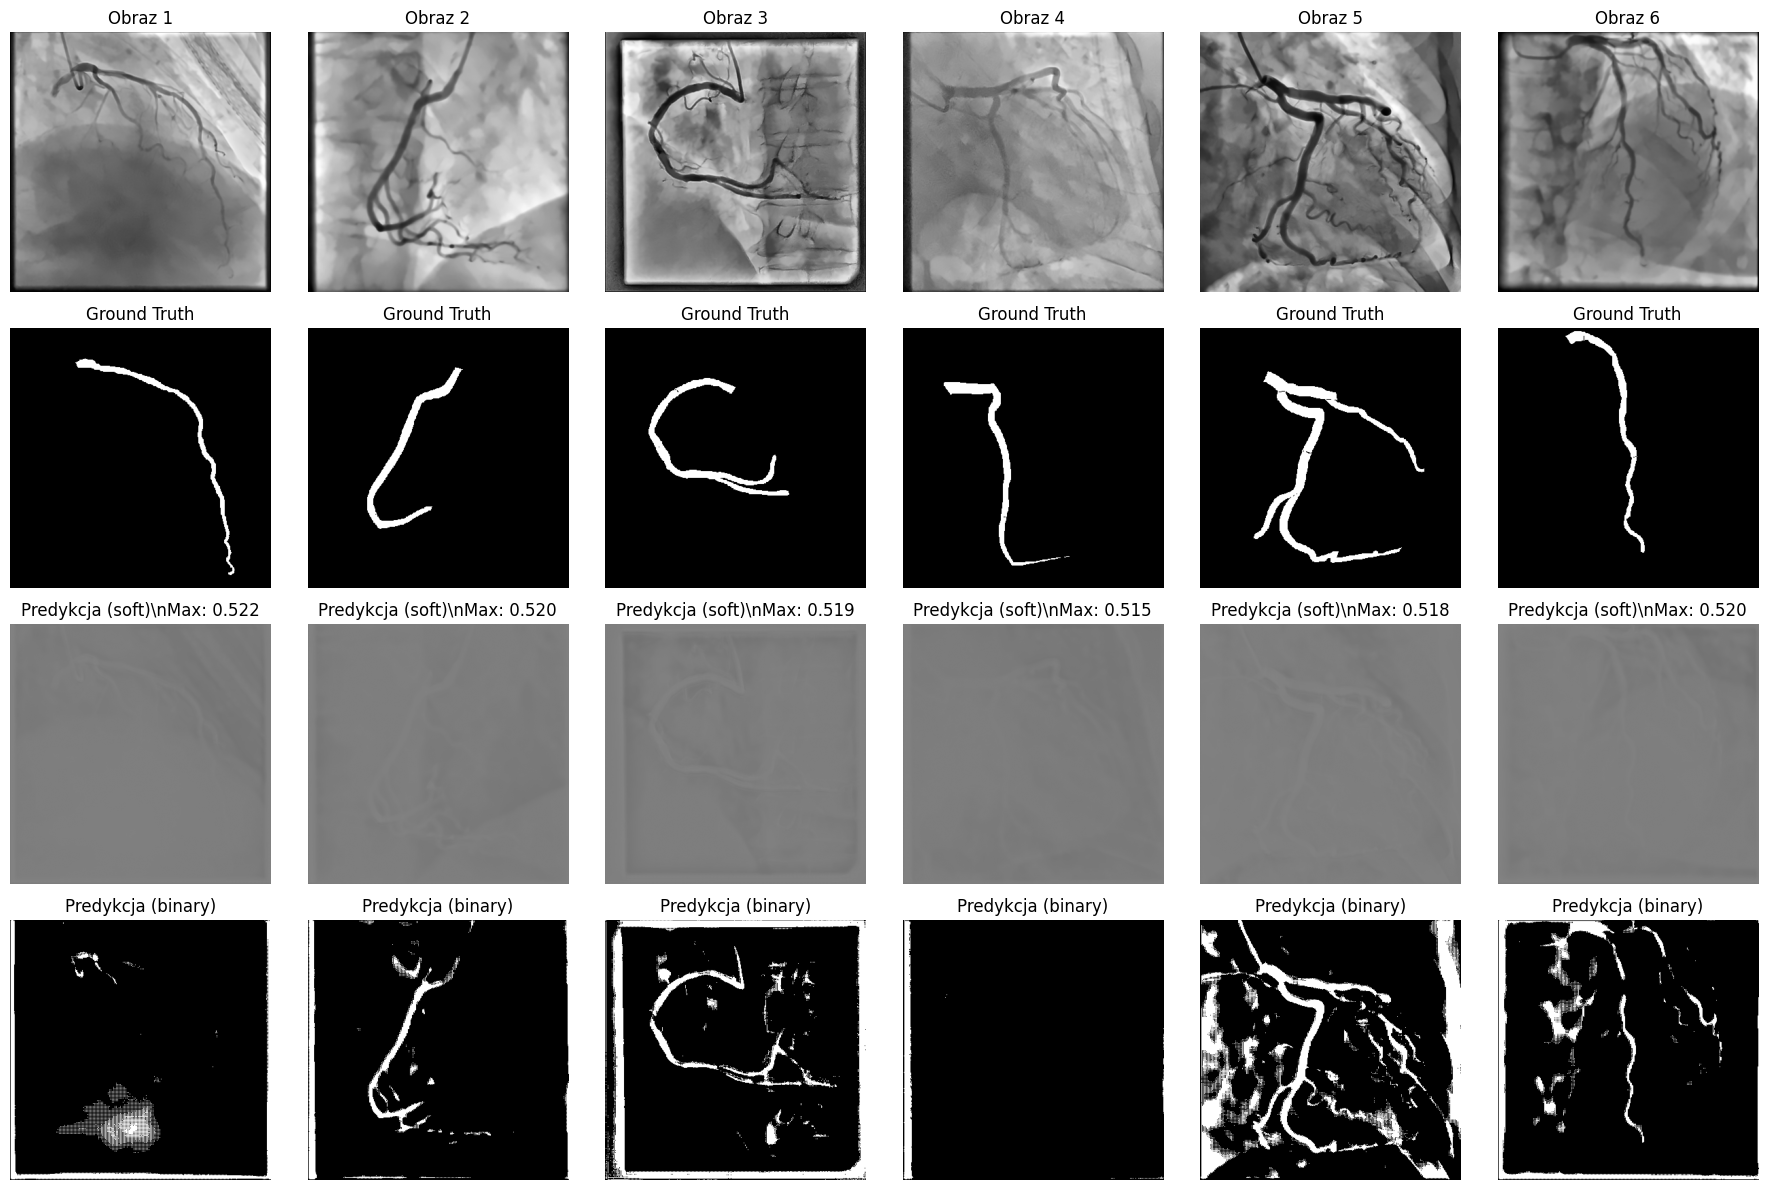

NameError: name 'history' is not defined

In [9]:
# Wizualizacja wyników
dataloaders = create_dataloaders(batch_size=8)
visualize_predictions(model, dataloaders['val'], num_samples=6)

# # Wykres treningu
plot_training_history(history)

# # Ewaluacja
metrics = evaluate_model(model, dataloaders['val'])

In [12]:
# TENSORBOARD - Monitoring treningu w czasie rzeczywistym

# Uruchom TensorBoard (odkomentuj poniższe linie)
%load_ext tensorboard
%tensorboard --logdir=runs

print("📱 TensorBoard:")
print("Odkomentuj linie powyżej aby uruchomić TensorBoard")
print("Będzie dostępny pod adresem: http://localhost:6006")
print("\\nMonitoruje:")
print("- Stratę treningu i walidacji")
print("- Metryki (Dice, IoU, BCE)")
print("- Parametry modelu")
print("- Histogramy wag")


Reusing TensorBoard on port 6006 (pid 171493), started 0:52:48 ago. (Use '!kill 171493' to kill it.)

📱 TensorBoard:
Odkomentuj linie powyżej aby uruchomić TensorBoard
Będzie dostępny pod adresem: http://localhost:6006
\nMonitoruje:
- Stratę treningu i walidacji
- Metryki (Dice, IoU, BCE)
- Parametry modelu
- Histogramy wag


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import torch
torch.cuda.empty_cache()
print("GPU cache cleared.")

GPU cache cleared.


In [ ]:
import gc

# del model # Delete model variable if it exists
# Delete other large variables that might be on GPU if necessary, e.g., del inputs, del labels, etc.

gc.collect()
torch.cuda.empty_cache()
print("Attempted to free up GPU memory.")

Attempted to free up GPU memory.


In [ ]:



# 🔮 INFERENCJA POJEDYNCZYCH ZDJĘĆ - GOOGLE COLAB

print("🔮 FUNKCJE INFERENCJI dla GOOGLE COLAB")
print("="*60)

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import cv2

def preprocess_single_image(image_path, resolution=512, apply_preprocessing=True):
    """
    Preprocessing pojedynczego obrazu identyczny jak w treningu

    Args:
        image_path: Ścieżka do obrazu
        resolution: Rozdzielczość modelu (256, 384, 512, etc.)
        apply_preprocessing: Czy zastosować CLAHE i denoising

    Returns:
        tensor: Przetworzony tensor gotowy do inferencji
    """

    # Załaduj obraz
    if isinstance(image_path, str):
        image = Image.open(image_path)
    else:
        image = image_path  # Już załadowany PIL Image

    # Konwertuj na grayscale
    if image.mode != 'L':
        image = image.convert('L')

    # Preprocessing (CLAHE + denoising) - identyczny jak w treningu
    if apply_preprocessing:
        preprocessor = ImagePreprocessor(
            apply_clahe=True,
            apply_denoise=True,
            clahe_clip_limit=2.0,
            clahe_tile_grid_size=(8, 8)
        )
        image = preprocessor(image)

    # Konwertuj do numpy
    image_np = np.array(image)

    # Augmentacje (tylko resize i normalizacja - jak w walidacji)
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

    transform = A.Compose([
        A.Resize(resolution, resolution),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

    # Zastosuj transformacje
    transformed = transform(image=image_np)
    image_tensor = transformed['image']

    # Dodaj batch dimension
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Dodaj channel dim

    image_tensor = image_tensor.unsqueeze(0)  # Dodaj batch dim: (1, 1, H, W)

    return image_tensor, image_np

def load_trained_model_for_inference(model_path, model_type=None, device=None):
    """
    Załaduj wytrenowany model do inferencji

    Args:
        model_path: Ścieżka do zapisanego modelu (.pth)
        model_type: Typ modelu ('unet', 'enhanced_unet', 'resunet')
        device: Urządzenie ('cuda', 'mps', 'cpu', lub None=auto)

    Returns:
        model: Załadowany model w trybie eval
        device: Urządzenie na którym jest model
    """

    # Auto-detect device
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")

    print(f"🔧 Loading model on: {device}")

    # Stwórz model
    model = create_model(model_type, n_class=1)

    # Załaduj wagi
    try:
        checkpoint = torch.load(model_path, map_location=device)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✅ Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
            print(f"📊 Training loss: {checkpoint.get('loss', 'unknown')}")
        else:
            # Stary format - tylko state_dict
            model.load_state_dict(checkpoint)
            print(f"✅ Model loaded (legacy format)")

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, device

    # Przenieś na device i ustaw eval mode
    model = model.to(device)
    model.eval()

    return model, device

def inference_single_image(model, image_tensor, device, threshold=0.5):
    """
    Inferencja pojedynczego obrazu

    Args:
        model: Załadowany model
        image_tensor: Przetworzony tensor obrazu
        device: Urządzenie
        threshold: Próg binaryzacji (0.5)

    Returns:
        prediction: Predykcja jako tensor
        prediction_binary: Zbinaryzowana predykcja
        confidence: Średnia pewność predykcji
    """

    with torch.no_grad():
        # Przenieś na device
        image_tensor = image_tensor.to(device)

        # Forward pass
        output = model(image_tensor)

        # Sigmoid dla prawdopodobieństw
        prediction = torch.sigmoid(output)

        # Binaryzacja
        prediction_binary = (prediction > threshold).float()

        # Statystyki
        confidence = prediction.mean().item()
        positive_pixels = prediction_binary.sum().item()
        total_pixels = prediction_binary.numel()
        positive_ratio = positive_pixels / total_pixels

        print(f"📊 Inference stats:")
        print(f"  - Average confidence: {confidence:.4f}")
        print(f"  - Positive pixels: {positive_pixels}/{total_pixels} ({positive_ratio*100:.2f}%)")

        return prediction, prediction_binary, confidence

def remove_small_components_from_mask(mask, min_size=500):
    """
    Usuwa małe komponenty z binarnej maski (np. < 500 pikseli)

    Args:
        mask: Binarna maska jako numpy array (0 i 1)
        min_size: Minimalny rozmiar komponentu do pozostawienia (w pikselach)

    Returns:
        mask_cleaned: Oczyszczona maska
    """
    import cv2
    import numpy as np

    # Konwertuj na uint8
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Znajdź komponenty połączone
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)

    # Stwórz nową pustą maskę
    mask_cleaned = np.zeros_like(mask, dtype=np.uint8)

    # Zostaw tylko duże komponenty
    for i in range(1, num_labels):  # pomiń tło (i=0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            mask_cleaned[labels == i] = 1

    return mask_cleaned


def visualize_inference_result(original_image, prediction, prediction_binary,
                              save_path=None, title="Coronary Artery Segmentation"):
    """
    Wizualizacja wyników inferencji

    Args:
        original_image: Oryginalny obraz (numpy array)
        prediction: Soft prediction (tensor)
        prediction_binary: Binary prediction (tensor)
        save_path: Ścieżka do zapisania (opcjonalne)
        title: Tytuł wykresu
    """

    # Konwertuj tensory na numpy
    pred_soft = prediction.cpu().squeeze().numpy()
    pred_binary = prediction_binary.cpu().squeeze().numpy()

    # Stwórz subplot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # 1. Oryginalny obraz
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # 2. Soft prediction (heatmapa)
    im1 = axes[1].imshow(pred_soft, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title(f'Prediction Heatmap\\nMax: {pred_soft.max():.3f}')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], shrink=0.6)

    # 3. Binary prediction
    axes[2].imshow(pred_binary, cmap='gray')
    axes[2].set_title('Binary Segmentation')
    axes[2].axis('off')

    # 4. Overlay
    # Resize original to match prediction
    if original_image.shape != pred_binary.shape:
        original_resized = cv2.resize(original_image, (pred_binary.shape[1], pred_binary.shape[0]))
    else:
        original_resized = original_image

    # Stwórz overlay
    overlay = original_resized.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB) if len(overlay.shape) == 2 else overlay

    # Dodaj maskę w kolorze czerwonym
    red_mask = np.zeros_like(overlay)
    red_mask[:, :, 0] = pred_binary * 255  # Czerwony kanał

    # Blend
    overlay_blended = cv2.addWeighted(overlay, 0.7, red_mask.astype(np.uint8), 0.3, 0)

    axes[3].imshow(overlay_blended)
    axes[3].set_title('Overlay (Red = Arteries)')
    axes[3].axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Zapisz jeśli podano ścieżkę
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Result saved to: {save_path}")

    plt.show()

    # Zwróć statystyki
    stats = {
        'max_confidence': pred_soft.max(),
        'mean_confidence': pred_soft.mean(),
        'positive_pixels': pred_binary.sum(),
        'positive_ratio': pred_binary.mean(),
        'image_shape': original_image.shape,
        'prediction_shape': pred_binary.shape
    }

    return stats

def full_inference_pipeline(image_path, model_path, model_type=None,
                           resolution=512, threshold=0.5, save_result=None):
    """
    Kompletny pipeline inferencji pojedynczego obrazu

    Args:
        image_path: Ścieżka do obrazu
        model_path: Ścieżka do modelu
        model_type: Typ modelu
        resolution: Rozdzielczość
        threshold: Próg binaryzacji
        save_result: Ścieżka do zapisania wyniku

    Returns:
        results: Słownik z wynikami
    """

    print(f"🔮 FULL INFERENCE PIPELINE")
    print(f"="*50)
    print(f"📁 Image: {image_path}")
    print(f"🧠 Model: {model_path}")
    print(f"📐 Resolution: {resolution}x{resolution}")
    print(f"🎯 Threshold: {threshold}")

    try:
        # 1. Załaduj model
        print(f"\\n1️⃣ Loading model...")
        model, device = load_trained_model_for_inference(model_path, model_type)
        if model is None:
            return None

        # 2. Preprocessing obrazu
        print(f"\\n2️⃣ Preprocessing image...")
        image_tensor, original_image = preprocess_single_image(image_path, resolution)
        print(f"   Original shape: {original_image.shape}")
        print(f"   Tensor shape: {image_tensor.shape}")

        # 3. Inferencja
        print(f"\\n3️⃣ Running inference...")
        prediction, prediction_binary, confidence = inference_single_image(
            model, image_tensor, device, threshold
        )

        # 3.5 Usuwanie małych komponentów
        print(f"\n🧹 Postprocessing (remove small objects)...")
        prediction_binary_np = prediction_binary.cpu().squeeze().numpy()
        prediction_binary_clean = remove_small_components_from_mask(prediction_binary_np, min_size=1000)

        # Konwertuj z powrotem do tensora
        prediction_binary = torch.tensor(prediction_binary_clean).unsqueeze(0).unsqueeze(0).to(device).float()

        # 4. Wizualizacja
        print(f"\\n4️⃣ Visualizing results...")
        stats = visualize_inference_result(
            original_image, prediction, prediction_binary,
            save_path=save_result,
            title=f"Coronary Segmentation - {Path(image_path).name}"
        )

        # 5. Podsumowanie
        print(f"\\n✅ INFERENCE COMPLETED!")
        print(f"📊 Results:")
        print(f"   Max confidence: {stats['max_confidence']:.4f}")
        print(f"   Mean confidence: {stats['mean_confidence']:.4f}")
        print(f"   Positive pixels: {stats['positive_pixels']:.0f} ({stats['positive_ratio']*100:.2f}%)")

        return {
            'model': model,
            'device': device,
            'original_image': original_image,
            'prediction': prediction,
            'prediction_binary': prediction_binary,
            'stats': stats,
            'image_path': image_path,
            'model_path': model_path
        }

    except Exception as e:
        print(f"❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None

print("✅ FUNKCJE INFERENCJI GOTOWE!")
print("\\n🔮 Główna funkcja:")
print("results = full_inference_pipeline(image_path, model_path)")
print("\\n📚 Dostępne funkcje:")
print("- preprocess_single_image() - preprocessing")
print("- load_trained_model_for_inference() - ładowanie modelu")
print("- inference_single_image() - inferencja")
print("- visualize_inference_result() - wizualizacja")
print("- full_inference_pipeline() - kompletny pipeline")

🔮 FUNKCJE INFERENCJI dla GOOGLE COLAB
✅ FUNKCJE INFERENCJI GOTOWE!
\n🔮 Główna funkcja:
results = full_inference_pipeline(image_path, model_path)
\n📚 Dostępne funkcje:
- preprocess_single_image() - preprocessing
- load_trained_model_for_inference() - ładowanie modelu
- inference_single_image() - inferencja
- visualize_inference_result() - wizualizacja
- full_inference_pipeline() - kompletny pipeline


In [105]:



# 📱 GOOGLE COLAB - UPLOAD I BATCH PROCESSING

print("📱 SPECJALNE FUNKCJE dla GOOGLE COLAB")
print("="*60)

def colab_upload_and_inference(model_path, model_type=None, resolution=512):
    """
    Interaktywny upload i inferencja w Google Colab

    Args:
        model_path: Ścieżka do wytrenowanego modelu
        model_type: Typ modelu
        resolution: Rozdzielczość
    """

    try:
        from google.colab import files
        print("🔥 GOOGLE COLAB DETECTED!")
    except ImportError:
        print("⚠️ Not running in Google Colab, using local file input")

        # Dla lokalnego użycia - podaj ścieżkę bezpośrednio
        image_path = input("📁 Enter image path: ")
        if not os.path.exists(image_path):
            print(f"❌ File not found: {image_path}")
            return None

        return full_inference_pipeline(image_path, model_path, model_type=model_type, resolution=resolution)

    print("📤 UPLOAD YOUR IMAGE:")
    print("Click 'Choose Files' and select an image...")

    # Upload plików
    uploaded = files.upload()

    if not uploaded:
        print("❌ No files uploaded!")
        return None

    # Przetwórz wszystkie uploaded pliki
    results = []

    for filename, data in uploaded.items():
        print(f"\\n🔮 Processing: {filename}")
        print("-" * 40)

        try:
            # Zapisz plik tymczasowo
            with open(filename, 'wb') as f:
                f.write(data)

            # Uruchom inferencję
            result = full_inference_pipeline(
                image_path=filename,
                model_path=model_path,
                model_type=model_type,
                resolution=resolution,
                save_result=f"result_{filename}.png"
            )

            if result:
                results.append(result)

                # Download wyników
                print(f"\\n💾 DOWNLOAD RESULTS:")
                try:
                    files.download(f"result_{filename}.png")
                    print(f"✅ Downloaded: result_{filename}.png")
                except:
                    print(f"⚠️ Could not download result")

            # Usuń tymczasowy plik
            try:
                os.remove(filename)
            except:
                pass

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

    print(f"\\n🎉 BATCH PROCESSING COMPLETED!")
    print(f"Processed {len(results)}/{len(uploaded)} files successfully")

    return results

def batch_inference_folder(folder_path, model_path, model_type=None,
                          resolution=512, save_folder=None):
    """
    Batch inferencja całego folderu obrazów

    Args:
        folder_path: Ścieżka do folderu z obrazami
        model_path: Ścieżka do modelu
        model_type: Typ modelu
        resolution: Rozdzielczość
        save_folder: Folder do zapisania wyników
    """

    print(f"📁 BATCH INFERENCE - FOLDER PROCESSING")
    print(f"="*60)
    print(f"📂 Source folder: {folder_path}")
    print(f"🧠 Model: {model_path}")

    if not os.path.exists(folder_path):
        print(f"❌ Folder not found: {folder_path}")
        return None

    # Znajdź wszystkie obrazy
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    image_files = []

    for ext in image_extensions:
        image_files.extend(Path(folder_path).glob(f"*{ext}"))
        image_files.extend(Path(folder_path).glob(f"*{ext.upper()}"))

    if not image_files:
        print(f"❌ No images found in {folder_path}")
        return None

    print(f"📊 Found {len(image_files)} images")

    # Stwórz folder wyników
    if save_folder is None:
        save_folder = f"{folder_path}_results"

    os.makedirs(save_folder, exist_ok=True)
    print(f"💾 Results will be saved to: {save_folder}")

    # Załaduj model raz
    print(f"\\n🔧 Loading model...")
    model, device = load_trained_model_for_inference(model_path, model_type)
    if model is None:
        return None

    # Batch processing
    results = []
    successful = 0

    print(f"\\n🚀 Starting batch processing...")

    for i, image_file in enumerate(image_files):
        print(f"\\n📷 [{i+1}/{len(image_files)}] Processing: {image_file.name}")

        try:
            # Preprocessing
            image_tensor, original_image = preprocess_single_image(str(image_file), resolution)

            # Inferencja
            prediction, prediction_binary, confidence = inference_single_image(
                model, image_tensor, device, threshold=0.5
            )

            # Zapisz wyniki
            result_path = os.path.join(save_folder, f"result_{image_file.stem}.png")
            stats = visualize_inference_result(
                original_image, prediction, prediction_binary,
                save_path=result_path,
                title=f"Coronary Segmentation - {image_file.name}"
            )

            results.append({
                'filename': image_file.name,
                'stats': stats,
                'result_path': result_path
            })

            successful += 1
            print(f"✅ Success - Confidence: {stats['mean_confidence']:.4f}")

        except Exception as e:
            print(f"❌ Failed: {e}")

    # Podsumowanie
    print(f"\\n🎉 BATCH PROCESSING COMPLETED!")
    print(f"✅ Successful: {successful}/{len(image_files)}")
    print(f"📁 Results saved in: {save_folder}")

    # Stwórz podsumowanie CSV
    try:
        import pandas as pd

        summary_data = []
        for result in results:
            summary_data.append({
                'filename': result['filename'],
                'max_confidence': result['stats']['max_confidence'],
                'mean_confidence': result['stats']['mean_confidence'],
                'positive_pixels': result['stats']['positive_pixels'],
                'positive_ratio_percent': result['stats']['positive_ratio'] * 100,
                'result_path': result['result_path']
            })

        df = pd.DataFrame(summary_data)
        csv_path = os.path.join(save_folder, 'batch_results_summary.csv')
        df.to_csv(csv_path, index=False)
        print(f"📊 Summary saved: {csv_path}")

        # Pokaż statystyki
        print(f"\\n📈 BATCH STATISTICS:")
        print(f"Mean confidence: {df['mean_confidence'].mean():.4f} ± {df['mean_confidence'].std():.4f}")
        print(f"Mean positive ratio: {df['positive_ratio_percent'].mean():.2f}% ± {df['positive_ratio_percent'].std():.2f}%")

    except ImportError:
        print("📊 Install pandas for CSV summary: !pip install pandas")

    return results

def quick_colab_demo(model_path="best_enhanced_unet_monai_focal_512x512.pth"):
    """
    Szybkie demo do testowania w Colab
    """

    print(f"🚀 QUICK COLAB DEMO")
    print(f"="*40)
    print(f"Upload image and run inference with one function!")

    # Auto-detect czy w Colab
    try:
        from google.colab import files
        in_colab = True
    except ImportError:
        in_colab = False
        print("⚠️ Not in Colab - use full_inference_pipeline() instead")
        return

    print(f"📤 UPLOAD YOUR CORONARY IMAGE:")

    # Demo code
    demo_code = f'''
# QUICK DEMO - SKOPIUJ I URUCHOM W COLAB:

# 1. Upload i inferencja jednym kliknięciem
results = colab_upload_and_inference(
    model_path="{model_path}",
    model_type='enhanced_unet',
    resolution=512
)

# 2. Lub batch processing lokalnego folderu
results = batch_inference_folder(
    folder_path="/content/my_images",
    model_path="{model_path}",
    resolution=512,
    save_folder="/content/results"
)

# 3. Pojedynczy obraz (jeśli już masz ścieżkę)
results = full_inference_pipeline(
    image_path="/content/coronary_image.jpg",
    model_path="{model_path}",
    resolution=512,
    save_result="/content/segmentation_result.png"
)
'''

    print(demo_code)

    return demo_code

print("✅ GOOGLE COLAB FUNCTIONS READY!")
print("\\n📱 COLAB-SPECIFIC FUNCTIONS:")
print("- colab_upload_and_inference() - interaktywny upload")
print("- batch_inference_folder() - batch processing")
print("- quick_colab_demo() - gotowe przykłady")

print("\\n🚀 QUICK START w GOOGLE COLAB:")
print("# Upload i analizuj obraz jednym kliknięciem:")
print("results = colab_upload_and_inference('your_model.pth')")

print("\\n# Lub zobacz demo:")
print("quick_colab_demo()")

📱 SPECJALNE FUNKCJE dla GOOGLE COLAB
✅ GOOGLE COLAB FUNCTIONS READY!
\n📱 COLAB-SPECIFIC FUNCTIONS:
- colab_upload_and_inference() - interaktywny upload
- batch_inference_folder() - batch processing
- quick_colab_demo() - gotowe przykłady
\n🚀 QUICK START w GOOGLE COLAB:
# Upload i analizuj obraz jednym kliknięciem:
results = colab_upload_and_inference('your_model.pth')
\n# Lub zobacz demo:
quick_colab_demo()


In [106]:



# 🎯 GOTOWY KOD DO SKOPIOWANIA - TWÓJ PROBLEM

print("🎯 GOTOWY KOD DO SKOPIOWANIA")
print("="*60)
print("Skopiuj kod poniżej do Google Colab i uruchom!")

# Kod do skopiowania
fixed_code = '''
# ===============================================
# NAPRAWIONY KOD - SKOPIUJ I URUCHOM W COLAB
# ===============================================

# 1. Auto-fix - najłatwiejszy sposób
print("🔧 AUTO-FIX ATTEMPT...")
results = quick_fix_model_loading(
    image_path="/content/drive/MyDrive/Colab Notebooks/9.png",
    model_path="/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth",
    resolution=512
)

if results:
    print("✅ AUTO-FIX SUCCESSFUL!")
else:
    print("🔄 Trying manual fix...")

    # 2. Ręczna naprawa z właściwym typem modelu
    results = full_inference_pipeline(
        image_path="/content/drive/MyDrive/Colab Notebooks/9.png",
        model_path="/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth",
        model_type='resunet',  # ← Właściwy typ dla Twojego modelu!
        resolution=512,
        threshold=0.5,
        save_result="/content/segmentation_result.png"
    )

    if results:
        print("✅ MANUAL FIX SUCCESSFUL!")

        # Download wyników
        try:
            from google.colab import files
            files.download("/content/segmentation_result.png")
            print("📥 Result downloaded!")
        except:
            print("💡 Result saved to: /content/segmentation_result.png")
    else:
        print("❌ Both fixes failed. Check your files.")
'''

print(fixed_code)

print(f"\\n📋 SZYBKA ŚCIĄGAWKA:")
print(f"="*30)

cheatsheet = {
    "ResUNet model": "model_type='resunet'",
    "Enhanced UNet model": "model_type='enhanced_unet'",
    "Basic UNet model": "model_type='unet'",
    "Auto-detection": "model_type=None  # (domyślne)",
    "Quick fix": "quick_fix_model_loading(image_path, model_path)",
    "Diagnoza tylko": "diagnose_model_loading_problem(model_path)"
}

for description, code in cheatsheet.items():
    print(f"• {description:<20}: {code}")

print(f"\\n🎯 TWÓJ KONKRETNY PRZYPADEK:")
print(f"="*40)

your_case = '''
PLIK MODELU: best_resunet_monai_dice.pth
TYP MODELU: resunet (z nazwy pliku)
PROBLEM: Kod próbował załadować jako enhanced_unet

ROZWIĄZANIE:
results = full_inference_pipeline(
    image_path="/content/drive/MyDrive/Colab Notebooks/9.png",
    model_path="/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth",
    model_type='resunet'  # ← To było brakujące!
)
'''

print(your_case)

print(f"\\n⚡ SZYBKIE POLECENIA:")
print(f"# Skopiuj i uruchom w Colab:")
print(f"quick_fix_model_loading('/content/drive/MyDrive/Colab Notebooks/9.png', '/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth')")

print(f"\\n✅ GOTOWE!")
print(f"Problem powinien być rozwiązany po użyciu kodu powyżej! 🚀")

🎯 GOTOWY KOD DO SKOPIOWANIA
Skopiuj kod poniżej do Google Colab i uruchom!

# ===============================================
# NAPRAWIONY KOD - SKOPIUJ I URUCHOM W COLAB
# ===============================================

# 1. Auto-fix - najłatwiejszy sposób
print("🔧 AUTO-FIX ATTEMPT...")
results = quick_fix_model_loading(
    image_path="/content/drive/MyDrive/Colab Notebooks/9.png",
    model_path="/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth",
    resolution=512
)

if results:
    print("✅ AUTO-FIX SUCCESSFUL!")
else:
    print("🔄 Trying manual fix...")

    # 2. Ręczna naprawa z właściwym typem modelu
    results = full_inference_pipeline(
        image_path="/content/drive/MyDrive/Colab Notebooks/9.png",
        model_path="/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth",
        model_type='resunet',  # ← Właściwy typ dla Twojego modelu!
        resolution=512,
        threshold=0.5,
        save_result="/content/segmentation_result.png"


In [107]:



# 🎯 GOTOWE PRZYKŁADY INFERENCJI - SKOPIUJ I UŻYJ!

print("🎯 GOTOWE PRZYKŁADY INFERENCJI")
print("="*60)
print("Skopiuj odpowiedni kod do swojego Google Colab!")

# PRZYKŁAD 1: Upload i inferencja w Colab
example_1 = '''
# ===== PRZYKŁAD 1: INTERAKTYWNY UPLOAD W COLAB =====

# 1. Załaduj notebook (skopiuj wszystkie komórki powyżej)

# 2. Uruchom inferencję z upload
results = colab_upload_and_inference(
    model_path="/content/best_enhanced_unet_monai_focal_512x512.pth",  # Ścieżka do modelu
    model_type='enhanced_unet',                                        # Typ modelu
    resolution=512                                                     # Rozdzielczość
)

# 3. Wyniki będą automatycznie wyświetlone i pobrane!
'''

# PRZYKŁAD 2: Pojedynczy obraz (jeśli masz ścieżkę)
example_2 = '''
# ===== PRZYKŁAD 2: POJEDYNCZY OBRAZ =====

# Jeśli już masz obraz w Colab (np. upload z Drive)
results = full_inference_pipeline(
    image_path="/content/coronary_image.jpg",                          # Ścieżka do obrazu
    model_path="/content/best_enhanced_unet_monai_focal_512x512.pth",  # Ścieżka do modelu
    model_type='enhanced_unet',                                        # Typ modelu
    resolution=512,                                                    # Rozdzielczość
    threshold=0.5,                                                     # Próg binaryzacji
    save_result="/content/segmentation_result.png"                    # Zapisz wynik
)

# Wyświetl dodatkowe statystyki
if results:
    print(f"✅ Inference completed!")
    print(f"Max confidence: {results['stats']['max_confidence']:.4f}")
    print(f"Detected arteries: {results['stats']['positive_ratio']*100:.2f}% of pixels")
'''

# PRZYKŁAD 3: Batch processing folderu
example_3 = '''
# ===== PRZYKŁAD 3: BATCH PROCESSING FOLDERU =====

# Upload całego folderu do Colab (ZIP → rozpakuj)
# !unzip my_coronary_images.zip -d /content/images/

# Przetwórz wszystkie obrazy
results = batch_inference_folder(
    folder_path="/content/images",                                     # Folder z obrazami
    model_path="/content/best_enhanced_unet_monai_focal_512x512.pth",  # Model
    model_type='enhanced_unet',                                        # Typ modelu
    resolution=512,                                                    # Rozdzielczość
    save_folder="/content/batch_results"                               # Folder wyników
)

# Pobranie wyników jako ZIP
# !zip -r batch_results.zip /content/batch_results
# from google.colab import files
# files.download('batch_results.zip')
'''

# PRZYKŁAD 4: Porównanie różnych progów
example_4 = '''
# ===== PRZYKŁAD 4: PORÓWNANIE RÓŻNYCH PROGÓW =====

import matplotlib.pyplot as plt

# Załaduj model raz
model, device = load_trained_model_for_inference(
    "/content/best_enhanced_unet_monai_focal_512x512.pth",
    'enhanced_unet'
)

# Preprocessing obrazu
image_tensor, original_image = preprocess_single_image(
    "/content/coronary_image.jpg",
    resolution=512
)

# Test różnych progów
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
fig, axes = plt.subplots(2, len(thresholds), figsize=(20, 8))

for i, threshold in enumerate(thresholds):
    # Inferencja
    prediction, prediction_binary, confidence = inference_single_image(
        model, image_tensor, device, threshold=threshold
    )

    # Konwertuj na numpy
    pred_soft = prediction.cpu().squeeze().numpy()
    pred_binary = prediction_binary.cpu().squeeze().numpy()

    # Wyświetl
    axes[0, i].imshow(pred_soft, cmap='jet')
    axes[0, i].set_title(f'Soft (t={threshold})')
    axes[0, i].axis('off')

    axes[1, i].imshow(pred_binary, cmap='gray')
    axes[1, i].set_title(f'Binary (t={threshold})\\n{pred_binary.sum():.0f} pixels')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
'''

# PRZYKŁAD 5: Google Drive integration
example_5 = '''
# ===== PRZYKŁAD 5: GOOGLE DRIVE INTEGRATION =====

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Skopiuj model z Drive
model_path = "/content/drive/MyDrive/coronary_models/best_model.pth"

# 3. Skopiuj obrazy z Drive
image_folder = "/content/drive/MyDrive/coronary_images/"

# 4. Uruchom batch processing
results = batch_inference_folder(
    folder_path=image_folder,
    model_path=model_path,
    resolution=512,
    save_folder="/content/drive/MyDrive/coronary_results/"  # Zapisz z powrotem na Drive
)

print(f"✅ Processed {len(results)} images")
print(f"📁 Results saved to Google Drive!")
'''

# PRZYKŁAD 6: Różne rozdzielczości
example_6 = '''
# ===== PRZYKŁAD 6: PORÓWNANIE ROZDZIELCZOŚCI =====

image_path = "/content/coronary_image.jpg"

# Test różnych rozdzielczości
resolutions = [256, 384, 512]
results_comparison = {}

for res in resolutions:
    print(f"\\n🔬 Testing {res}x{res}...")

    # Znajdź odpowiedni model (lub użyj tego samego)
    model_path = f"/content/best_enhanced_unet_{res}x{res}.pth"

    try:
        result = full_inference_pipeline(
            image_path=image_path,
            model_path=model_path,
            resolution=res,
            save_result=f"/content/result_{res}x{res}.png"
        )

        if result:
            results_comparison[res] = result['stats']
            print(f"✅ {res}x{res}: Confidence={result['stats']['mean_confidence']:.4f}")

    except Exception as e:
        print(f"❌ {res}x{res}: {e}")

# Porównanie wyników
print(f"\\n🏆 RESOLUTION COMPARISON:")
for res, stats in results_comparison.items():
    print(f"{res}x{res}: Confidence={stats['mean_confidence']:.4f}, "
          f"Positive={stats['positive_ratio']*100:.2f}%")
'''

# Wyświetl wszystkie przykłady
examples = [
    ("🔥 INTERAKTYWNY UPLOAD", example_1),
    ("📷 POJEDYNCZY OBRAZ", example_2),
    ("📁 BATCH PROCESSING", example_3),
    ("🎚️ PORÓWNANIE PROGÓW", example_4),
    ("☁️ GOOGLE DRIVE", example_5),
    ("📐 PORÓWNANIE ROZDZIELCZOŚCI", example_6)
]

print(f"\\n📚 DOSTĘPNE PRZYKŁADY:")
for i, (title, code) in enumerate(examples, 1):
    print(f"{i}. {title}")

print(f"\\n" + "="*60)
print(f"🚀 ZALECANY WORKFLOW dla GOOGLE COLAB:")
print(f"="*60)

workflow = '''
# KROK 1: Skopiuj wszystkie komórki z funkcjami (Cell 16-17)

# KROK 2: Upload model do Colab
from google.colab import files
uploaded_model = files.upload()  # Upload .pth file

# KROK 3: Uruchom inferencję
results = colab_upload_and_inference(
    model_path="your_model.pth",    # Nazwa uploaded file
    resolution=512                  # Dopasuj do modelu
)

# KROK 4: Rezultaty są automatycznie wyświetlone i pobrane!
'''

print(workflow)

print(f"\\n💡 WSKAZÓWKI dla COLAB:")
print(f"• Upload model (.pth) do /content/")
print(f"• Sprawdź rozdzielczość modelu (256/384/512)")
print(f"• Użyj resolution=512 dla najlepszych wyników")
print(f"• Wyniki są automatycznie pobierane")
print(f"• Dla batch processing: zip folder → upload → unzip")

print(f"\\n🔗 QUICK LINKS:")
print(f"• Single image: full_inference_pipeline()")
print(f"• Upload & inference: colab_upload_and_inference()")
print(f"• Batch folder: batch_inference_folder()")
print(f"• Get examples: quick_colab_demo()")

print(f"\\n✅ GOTOWE DO UŻYCIA W GOOGLE COLAB!")
print(f"Skopiuj odpowiedni przykład i uruchom! 🚀")

🎯 GOTOWE PRZYKŁADY INFERENCJI
Skopiuj odpowiedni kod do swojego Google Colab!
\n📚 DOSTĘPNE PRZYKŁADY:
1. 🔥 INTERAKTYWNY UPLOAD
2. 📷 POJEDYNCZY OBRAZ
3. 📁 BATCH PROCESSING
4. 🎚️ PORÓWNANIE PROGÓW
5. ☁️ GOOGLE DRIVE
6. 📐 PORÓWNANIE ROZDZIELCZOŚCI
\n============================================================
🚀 ZALECANY WORKFLOW dla GOOGLE COLAB:

# KROK 1: Skopiuj wszystkie komórki z funkcjami (Cell 16-17)

# KROK 2: Upload model do Colab
from google.colab import files
uploaded_model = files.upload()  # Upload .pth file

# KROK 3: Uruchom inferencję
results = colab_upload_and_inference(
    model_path="your_model.pth",    # Nazwa uploaded file
    resolution=512                  # Dopasuj do modelu
)

# KROK 4: Rezultaty są automatycznie wyświetlone i pobrane!

\n💡 WSKAZÓWKI dla COLAB:
• Upload model (.pth) do /content/
• Sprawdź rozdzielczość modelu (256/384/512)
• Użyj resolution=512 dla najlepszych wyników
• Wyniki są automatycznie pobierane
• Dla batch processing: zip folder → upload

🔮 FULL INFERENCE PIPELINE
📁 Image: /home/ives/rafal/notebooks/a.jpg
🧠 Model: /home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth
📐 Resolution: 512x512
🎯 Threshold: 0.5
\n1️⃣ Loading model...
🔧 Loading model on: cuda
✅ Model loaded from epoch 49
📊 Training loss: 0.6177974087851388
\n2️⃣ Preprocessing image...
   Original shape: (683, 800)
   Tensor shape: torch.Size([1, 1, 512, 512])
\n3️⃣ Running inference...
📊 Inference stats:
  - Average confidence: 0.0914
  - Positive pixels: 23930.0/262144 (9.13%)

🧹 Postprocessing (remove small objects)...
\n4️⃣ Visualizing results...


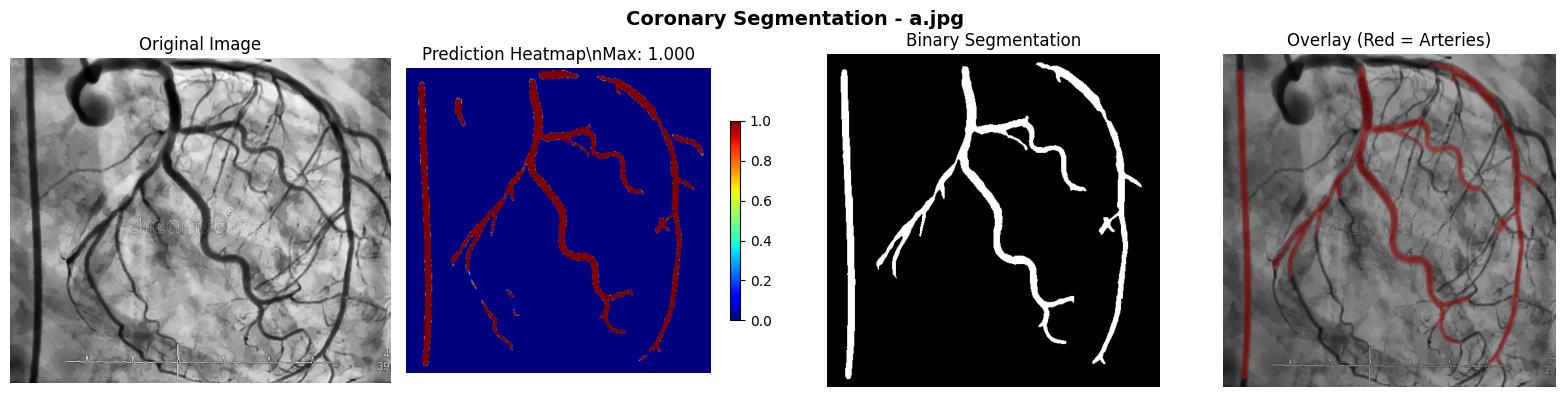

\n✅ INFERENCE COMPLETED!
📊 Results:
   Max confidence: 1.0000
   Mean confidence: 0.0914
   Positive pixels: 21580 (8.23%)


In [105]:
# Pojedynczy obraz - kompletny pipeline
results = full_inference_pipeline("/home/ives/rafal/notebooks/a.jpg", "/home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth", model_type='resunet', resolution=512)

# Upload w Colab
# results = colab_upload_and_inference("/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth")

# Batch folder
# results = batch_inference_folder(folder_path, model_path)

In [ ]:
# 🔮 ENHANCED INFERENCE PIPELINE - GOOGLE COLAB

print("🔮 ENHANCED INFERENCE PIPELINE dla GOOGLE COLAB")
print("="*60)

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import cv2
from typing import Tuple, List, Dict, Optional
import albumentations as A
from albumentations.pytorch import ToTensorV2

class EnhancedInferenceEngine:
    """
    Zaawansowany silnik inferencji z multi-resolution support
    """
    
    def __init__(self, model_path: str, model_type: str = None, 
                 device: str = None, resolutions: List[int] = [256, 320, 384, 448, 512]):
        """
        Inicjalizacja silnika inferencji
        
        Args:
            model_path: Ścieżka do wytrenowanego modelu
            model_type: Typ modelu ('unet', 'enhanced_unet', 'resunet')
            device: Urządzenie ('cuda', 'mps', 'cpu', lub None=auto)
            resolutions: Lista rozdzielczości do testowania
        """
        self.model_path = model_path
        self.model_type = model_type
        self.resolutions = resolutions
        
        # Auto-detect device
        if device is None:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            elif torch.backends.mps.is_available():
                self.device = torch.device("mps")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = torch.device(device)
        
        print(f"🔧 Initializing on device: {self.device}")
        
        # Załaduj model
        self.model = self._load_model()
        
    def _load_model(self):
        """Załaduj wytrenowany model"""
        try:
            # Stwórz model
            model = create_model(self.model_type, n_class=1)
            
            # Załaduj wagi
            checkpoint = torch.load(self.model_path, map_location=self.device)
            
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"✅ Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
                print(f"📊 Training loss: {checkpoint.get('loss', 'unknown'):.4f}")
            else:
                model.load_state_dict(checkpoint)
                print(f"✅ Model loaded (legacy format)")
            
            # Przenieś na device i ustaw eval mode
            model = model.to(self.device)
            model.eval()
            
            return model
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            raise e
    
    def preprocess_image(self, image_path: str, resolution: int, 
                        apply_preprocessing: bool = True) -> Tuple[torch.Tensor, np.ndarray]:
        """
        Preprocessing pojedynczego obrazu dla konkretnej rozdzielczości
        
        Args:
            image_path: Ścieżka do obrazu lub PIL Image
            resolution: Rozdzielczość do której zmienić obraz
            apply_preprocessing: Czy zastosować CLAHE i denoising
            
        Returns:
            image_tensor: Przetworzony tensor
            image_np: Oryginalny obraz jako numpy array
        """
        
        # Załaduj obraz
        if isinstance(image_path, str):
            image = Image.open(image_path)
        else:
            image = image_path  # Już załadowany PIL Image
        
        # Konwertuj na grayscale
        if image.mode != 'L':
            image = image.convert('L')
        
        # Preprocessing (CLAHE + denoising) - identyczny jak w treningu
        if apply_preprocessing:
            try:
                preprocessor = ImagePreprocessor(
                    apply_clahe=True,
                    apply_denoise=True,
                    clahe_clip_limit=2.0,
                    clahe_tile_grid_size=(8, 8)
                )
                image = preprocessor(image)
            except:
                print("⚠️ ImagePreprocessor not available, skipping preprocessing")
        
        # Konwertuj do numpy (oryginalny rozmiar)
        original_image_np = np.array(image)
        
        # Augmentacje (tylko resize i normalizacja)
        transform = A.Compose([
            A.Resize(resolution, resolution),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ])
        
        # Zastosuj transformacje
        transformed = transform(image=original_image_np)
        image_tensor = transformed['image']
        
        # Dodaj wymiary
        if len(image_tensor.shape) == 2:
            image_tensor = image_tensor.unsqueeze(0)  # Channel dim
        image_tensor = image_tensor.unsqueeze(0)  # Batch dim
        
        return image_tensor, original_image_np
    
    def single_resolution_inference(self, image_path: str, resolution: int, 
                                  threshold: float = 0.5, min_size: int = 500) -> Dict:
        """
        Inferencja dla pojedynczej rozdzielczości
        
        Args:
            image_path: Ścieżka do obrazu
            resolution: Rozdzielczość
            threshold: Próg binaryzacji
            
        Returns:
            results: Słownik z wynikami
        """
        
        # Preprocessing
        image_tensor, original_image = self.preprocess_image(image_path, resolution)
        
        # Inferencja
        with torch.no_grad():
            image_tensor = image_tensor.to(self.device)
            output = self.model(image_tensor)
            prediction = torch.sigmoid(output)
        
        # Resize do oryginalnego rozmiaru
        original_h, original_w = original_image.shape[:2]
        prediction_resized = torch.nn.functional.interpolate(
            prediction, 
            size=(original_h, original_w), 
            mode='bilinear', 
            align_corners=False
        )
        
        # Konwertuj do numpy
        pred_np = prediction_resized.cpu().squeeze().numpy()
        
        # Binaryzacja
        pred_binary = (pred_np > threshold).astype(np.float32)
        
        # Postprocessing - usuń małe komponenty
        pred_binary_clean = self._remove_small_components(pred_binary, min_size=min_size)
        
        # Analiza wyników
        results = {
            'resolution': resolution,
            'prediction_soft': pred_np,
            'prediction_binary': pred_binary_clean,
            'original_image': original_image,
            'max_confidence': float(pred_np.max()),
            'mean_confidence': float(pred_np.mean()),
            'std_confidence': float(pred_np.std()),
            'positive_pixels': int(pred_binary_clean.sum()),
            'positive_ratio': float(pred_binary_clean.mean()),
            'total_pixels': pred_binary_clean.size
        }
        
        # Dodatkowe metryki
        results['confidence_above_threshold'] = float((pred_np > threshold).mean())
        
        # Connected components analysis
        num_components, _ = cv2.connectedComponents(pred_binary_clean.astype(np.uint8))
        results['connected_components'] = num_components - 1  # -1 bo 0 to tło
        
        return results
    
    def multi_resolution_inference(self, image_path: str, threshold: float = 0.5,
                                 selection_strategy: str = 'max_positive_pixels', min_size: int = 500) -> Dict:
        """
        Multi-resolution inference - testuje wszystkie rozdzielczości
        
        Args:
            image_path: Ścieżka do obrazu
            threshold: Próg binaryzacji
            selection_strategy: Strategia wyboru najlepszej rozdzielczości
            
        Returns:
            results: Słownik z wynikami wszystkich rozdzielczości i najlepszą
        """
        
        print(f"🔍 Multi-resolution inference: {len(self.resolutions)} rozdzielczości")
        print(f"📁 Image: {Path(image_path).name}")
        print(f"🎯 Threshold: {threshold}")
        print(f"📋 Strategy: {selection_strategy}")
        print("-" * 60)
        
        all_results = []
        
        # Test każdej rozdzielczości
        for i, resolution in enumerate(self.resolutions, 1):
            print(f"[{i}/{len(self.resolutions)}] Testing {resolution}x{resolution}...", end=" ")
            
            result = self.single_resolution_inference(image_path, resolution, threshold, min_size=min_size)
            all_results.append(result)
            
            print(f"Pixels: {result['positive_pixels']:4d} "
                  f"({result['positive_ratio']:.1%}), "
                  f"Max conf: {result['max_confidence']:.4f}, "
                  f"Components: {result['connected_components']}")
        
        # Wybierz najlepszą rozdzielczość
        best_result = self._select_best_resolution(all_results, selection_strategy)
        
        print(f"\n🏆 Best resolution: {best_result['resolution']}x{best_result['resolution']}")
        print(f"   Strategy: {selection_strategy}")
        print(f"   Positive pixels: {best_result['positive_pixels']} ({best_result['positive_ratio']:.1%})")
        print(f"   Max confidence: {best_result['max_confidence']:.4f}")
        
        return {
            'best_result': best_result,
            'all_results': all_results,
            'strategy_used': selection_strategy,
            'image_path': image_path,
            'threshold': threshold
        }
    
    def _select_best_resolution(self, results: List[Dict], strategy: str) -> Dict:
        """Wybierz najlepszą rozdzielczość według strategii"""
        
        if strategy == 'max_positive_pixels':
            return max(results, key=lambda x: x['positive_pixels'])
        
        elif strategy == 'max_confidence':
            return max(results, key=lambda x: x['mean_confidence'])
        
        elif strategy == 'balanced':
            # Balans: normalizuj obie metryki i weź średnią ważoną
            max_pixels = max(r['positive_pixels'] for r in results)
            max_conf = max(r['mean_confidence'] for r in results)
            
            def balanced_score(r):
                norm_pixels = r['positive_pixels'] / max_pixels if max_pixels > 0 else 0
                norm_conf = r['mean_confidence'] / max_conf if max_conf > 0 else 0
                return 0.7 * norm_pixels + 0.3 * norm_conf
            
            return max(results, key=balanced_score)
        
        elif strategy == 'max_components':
            return max(results, key=lambda x: x['connected_components'])
        
        elif strategy == 'best_quality':
            # Kombinacja wysokiej pewności i reasonable liczby pikseli
            def quality_score(r):
                # Penalizuj bardzo małą liczbę pikseli lub bardzo dużą
                pixel_score = r['positive_ratio']
                if r['positive_ratio'] < 0.01:  # < 1%
                    pixel_score *= 0.1
                elif r['positive_ratio'] > 0.15:  # > 15%
                    pixel_score *= 0.5
                    
                return r['max_confidence'] * 0.6 + pixel_score * 0.4
            
            return max(results, key=quality_score)
        
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
    
    # def _remove_small_components(self, mask: np.ndarray, min_size: int = 1200) -> np.ndarray:
    #     """Usuń małe komponenty z maski"""
    #     mask_uint8 = (mask * 255).astype(np.uint8)
    #     num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
        
    #     mask_cleaned = np.zeros_like(mask, dtype=np.float32)
        
    #     for i in range(1, num_labels):  # pomiń tło (i=0)
    #         if stats[i, cv2.CC_STAT_AREA] >= min_size:
    #             mask_cleaned[labels == i] = 1.0
        
    #     return mask_cleaned

    def _remove_small_components(self, mask: np.ndarray, min_size: int = 500) -> np.ndarray:
        """
        Usuń małe komponenty z maski z lepszą obsługą różnych typów danych
        
        Args:
            mask: Binarna maska (0-1 lub 0-255)
            min_size: Minimalny rozmiar komponentu w pikselach
            
        Returns:
            mask_cleaned: Oczyszczona maska (0.0-1.0)
        """
        
        # Normalizuj maskę do zakresu 0-1
        if mask.max() > 1.0:
            mask_normalized = mask / 255.0
        else:
            mask_normalized = mask
            
        # Konwertuj na binarną maskę uint8
        mask_binary = (mask_normalized > 0.5).astype(np.uint8)
        
        # Znajdź komponenty połączone
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            mask_binary, connectivity=8
        )

        print(f"🔍 Component analysis:")
        print(f"   Total components found: {num_labels - 1}")  # -1 bo 0 to tło
        
        if num_labels <= 1:  # Tylko tło
            print(f"   No foreground components found")
            return np.zeros_like(mask, dtype=np.float32)

        # Pokaż wszystkie komponenty
        areas = []
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            areas.append(area)
            print(f"   Component {i}: {area} pixels")

        # Stwórz nową pustą maskę
        mask_cleaned = np.zeros_like(mask, dtype=np.float32)
        
        # Zachowaj tylko komponenty większe niż min_size
        kept_components = 0
        total_kept_pixels = 0
        
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= min_size:
                mask_cleaned[labels == i] = 1.0
                kept_components += 1
                total_kept_pixels += area
            else:
                print(f"   ❌ Removing component {i} (area: {area} < min_size: {min_size})")

        print(f"   ✅ Kept {kept_components} components ({total_kept_pixels} pixels total)")
        
        # Jeśli żaden komponent nie został zachowany, ale istnieją komponenty
        if kept_components == 0 and len(areas) > 0:
            largest_area = max(areas)
            print(f"   ⚠️  No components above threshold! Largest was {largest_area} pixels.")
            print(f"   💡 Consider lowering min_size to {largest_area // 2} or less")

        return mask_cleaned

    def visualize_multi_resolution_results(self, inference_results: Dict,
                                           save_path: Optional[str] = None):
        """
        Wizualizuj wyniki inferencji wielorozdzielczej.

        Prezentuje oryginalny obraz, mapę ciepła predykcji oraz binarną maskę
        dla każdej testowanej rozdzielczości, wyróżniając najlepszy wynik.

        Args:
            inference_results: Wyniki zwrócone przez `multi_resolution_inference`.
            save_path: Opcjonalna ścieżka do zapisania wykresu. Jeśli None, wykres jest tylko wyświetlany.
        """

        all_results = inference_results['all_results']
        best_result = inference_results['best_result']
        image_name = Path(inference_results['image_path']).name
        threshold = inference_results['threshold']

        n_resolutions = len(all_results)
        fig, axes = plt.subplots(3, n_resolutions, figsize=(4 * n_resolutions, 12))

        # Handle case with single resolution more gracefully for axes indexing
        if n_resolutions == 1:
            axes = axes.reshape(3, 1)

        for i, result in enumerate(all_results):
            resolution = result['resolution']
            original = result['original_image']
            pred_soft = result['prediction_soft']
            pred_binary = result['prediction_binary']

            is_best = (resolution == best_result['resolution'])

            # 1. Oryginalny obraz
            axes[0, i].imshow(original, cmap='gray')
            title = f'{resolution}x{resolution}'
            if is_best:
                title = f"⭐ {title} ⭐\nStrategy: {inference_results['strategy_used']}"
                # Highlight best result
                for spine in axes[0, i].spines.values():
                    spine.set_edgecolor('green')
                    spine.set_linewidth(3)
            axes[0, i].set_title(title, fontsize=10)
            axes[0, i].axis('off')

            # 2. Soft prediction (heatmapa)
            im = axes[1, i].imshow(pred_soft, cmap='hot', vmin=0, vmax=1)
            axes[1, i].set_title(f'Max: {result["max_confidence"]:.3f}\nMean: {result["mean_confidence"]:.3f}', fontsize=9)
            axes[1, i].axis('off')

            # 3. Overlay - POPRAWIONE (pokazuje tylko obiekty po filtracji)
            # Stwórz overlay z oryginalnym obrazem i oczyszczoną binarną predykcją
            overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)
            
            # Użyj oczyszczonej binarnej maski (po usunięciu małych komponentów)
            # To zapewni zgodność między overlay a statystykami
            binary_scaled = (pred_binary * 255).astype(np.uint8)
            
            # Stwórz kolorową maskę (czerwoną) z oczyszczonej binarnej maski
            red_mask = np.zeros_like(overlay)
            red_mask[:, :, 0] = binary_scaled  # Czerwony kanał z oczyszczonej maski
            
            # Jeśli nie ma żadnych obiektów po filtracji, pokaż soft prediction z niską intensywnością
            if pred_binary.sum() == 0:
                # Fallback: użyj soft prediction ale z bardzo niską intensywnością
                soft_scaled = (pred_soft * 50).astype(np.uint8)  # Bardzo słabe
                red_mask[:, :, 0] = soft_scaled
                # Dodaj informację o fallback
                overlay_info = "(Fallback: soft pred)"
            else:
                overlay_info = "(Filtered binary)"
            
            # Blend oryginalny obraz z kolorową maską
            overlay_blended = cv2.addWeighted(overlay, 0.6, red_mask, 0.4, 0)
            
            axes[2, i].imshow(overlay_blended)
            
            # Informacje o wynikach
            binary_pixels = int(pred_binary.sum())
            max_soft_value = float(pred_soft.max())
            mean_soft_value = float(pred_soft.mean())
            
            # Dodaj informacje o threshold i wynikach
            title_text = f'Overlay {overlay_info}\n'
            title_text += f'Binary: {binary_pixels} px ({result["positive_ratio"]:.1%})\n'
            title_text += f'Soft max: {max_soft_value:.3f}'
            
            axes[2, i].set_title(title_text, fontsize=8)
            axes[2, i].axis('off')

        plt.suptitle(f'Multi-Resolution Inference Results for {image_name}',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Visualization saved to: {save_path}")

        plt.show()

        # Szczegółowe wyniki w konsoli
        print(f"\n📊 Detailed Results for {image_name}:")
        print(f"Threshold used: {threshold}")
        print("-" * 80)
        print(f"{'':2s} {'Res':>7s} {'Pixels':>7s} {'Ratio':>7s} {'Max':>7s} {'Mean':>7s} {'Comp':>5s}")
        print("-" * 80)

        for result in all_results:
            marker = "⭐" if result['resolution'] == best_result['resolution'] else "  "
            print(f"{marker} {result['resolution']:3d}x{result['resolution']:3d} "
                  f"{result['positive_pixels']:6d} "
                  f"{result['positive_ratio']:6.1%} "
                  f"{result['max_confidence']:6.4f} "
                  f"{result['mean_confidence']:6.4f} "
                  f"{result['connected_components']:4d}")
        
        # Dodaj rekomendację dotyczącą threshold
        if all(r['positive_pixels'] == 0 for r in all_results):
            max_conf = max(r['max_confidence'] for r in all_results)
            mean_conf = max(r['mean_confidence'] for r in all_results)
            print(f"\n⚠️  WARNING: No pixels above threshold {threshold}")
            print(f"💡 RECOMMENDATION: Try lower threshold (e.g., {max_conf*0.5:.3f} or {mean_conf*2:.3f})")
    # def visualize_multi_resolution_results(self, inference_results: Dict, 
    #                                      save_path: Optional[str] = None):
    #     """
    #     Wizualizuj wyniki multi-resolution inference
        
    #     Args:
    #         inference_results: Wyniki z multi_resolution_inference
    #         save_path: Ścieżka do zapisania wyników
    #     """
        
    #     all_results = inference_results['all_results']
    #     best_result = inference_results['best_result']
        
    #     n_resolutions = len(all_results)
    #     fig, axes = plt.subplots(3, n_resolutions, figsize=(4*n_resolutions, 12))
        
    #     if n_resolutions == 1:
    #         axes = axes.reshape(3, 1)
        
    #     for i, result in enumerate(all_results):
    #         resolution = result['resolution']
    #         original = result['original_image']
    #         pred_soft = result['prediction_soft']
    #         pred_binary = result['prediction_binary']
            
    #         is_best = (resolution == best_result['resolution'])
            
    #         # 1. Oryginalny obraz
    #         axes[0, i].imshow(original, cmap='gray')
    #         title = f'{resolution}x{resolution}'
    #         if is_best:
    #             title = f"⭐ {title} ⭐"
    #             axes[0, i].set_facecolor('lightgreen')
    #         axes[0, i].set_title(title)
    #         axes[0, i].axis('off')
            
    #         # 2. Soft prediction (heatmapa)
    #         im = axes[1, i].imshow(pred_soft, cmap='hot', vmin=0, vmax=1)
    #         axes[1, i].set_title(f'Max: {result["max_confidence"]:.3f}\\nMean: {result["mean_confidence"]:.3f}')
    #         axes[1, i].axis('off')
            
    #         # 3. Binary + overlay
    #         # Stwórz overlay
    #         overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)
    #         red_mask = np.zeros_like(overlay)
    #         red_mask[:, :, 0] = pred_binary * 255
    #         overlay_blended = cv2.addWeighted(overlay, 0.7, red_mask.astype(np.uint8), 0.3, 0)
            
    #         axes[2, i].imshow(overlay_blended)
    #         axes[2, i].set_title(f'Pixels: {result["positive_pixels"]}\\n({result["positive_ratio"]:.1%})')
    #         axes[2, i].axis('off')
        
    #     plt.suptitle(f'Multi-Resolution Results - Strategy: {inference_results["strategy_used"]}', 
    #                 fontsize=16, fontweight='bold')
    #     plt.tight_layout()
        
    #     if save_path:
    #         plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #         print(f"💾 Visualization saved to: {save_path}")
        
    #     plt.show()
        
    #     # Szczegółowe wyniki
    #     print(f"\n📊 Detailed Results:")
    #     print("-" * 80)
    #     print(f"{'':2s} {'Res':>7s} {'Pixels':>7s} {'Ratio':>7s} {'Max':>7s} {'Mean':>7s} {'Comp':>5s}")
    #     print("-" * 80)
        
    #     for result in all_results:
    #         marker = "⭐" if result['resolution'] == best_result['resolution'] else "  "
    #         print(f"{marker} {result['resolution']:3d}x{result['resolution']:3d} "
    #               f"{result['positive_pixels']:6d} "
    #               f"{result['positive_ratio']:6.1%} "
    #               f"{result['max_confidence']:6.4f} "
    #               f"{result['mean_confidence']:6.4f} "
    #               f"{result['connected_components']:4d}")

    
# print(f"🚀 ENHANCED INFERENCE PIPELINE")
# print(f"="*60)
# print(f"📁 Image: {image_path}")
# print(f"🧠 Model: {model_path}")
# print(f"📐 Resolutions: {resolutions}")
# print(f"🎯 Threshold: {threshold}")
# print(f"📋 Strategy: {strategy}")

# try:
#     # 1. Inicjalizuj silnik
#     print(f"\n1️⃣ Initializing inference engine...")
#     engine = EnhancedInferenceEngine(
#         model_path=model_path,
#         model_type=model_type,
#         resolutions=resolutions
#     )
    
#     # 2. Multi-resolution inference
#     print(f"\n2️⃣ Running multi-resolution inference...")
#     results = engine.multi_resolution_inference(
#         image_path=image_path,
#         threshold=threshold,
#         selection_strategy=strategy
#     )
    
#     # 3. Wizualizacja
#     print(f"\n3️⃣ Visualizing results...")
#     engine.visualize_multi_resolution_results(results, save_visualization)
    
#     # 4. Podsumowanie
#     best = results['best_result']
#     print(f"\n✅ ENHANCED INFERENCE COMPLETED!")
#     print(f"🏆 Best Configuration:")
#     print(f"   Resolution: {best['resolution']}x{best['resolution']}")
#     print(f"   Positive pixels: {best['positive_pixels']} ({best['positive_ratio']:.1%})")
#     print(f"   Max confidence: {best['max_confidence']:.4f}")
#     print(f"   Mean confidence: {best['mean_confidence']:.4f}")
#     print(f"   Connected components: {best['connected_components']}")
    
#     # Dodaj silnik do wyników
#     results['engine'] = engine
    
#     return results
    
# except Exception as e:
#     print(f"❌ Enhanced pipeline failed: {e}")
#     import traceback
#     traceback.print_exc()
#     return None


# def legacy_inference_pipeline(image_path: str, model_path: str, model_type: str = None,
#                             resolution: int = 512, threshold: float = 0.5, 
#                             save_result: Optional[str] = None) -> Dict:
#     """
#     Legacy pipeline kompatybilny z oryginalnym kodem (single resolution)
    
#     Args:
#         image_path: Ścieżka do obrazu
#         model_path: Ścieżka do modelu
#         model_type: Typ modelu
#         resolution: Pojedyncza rozdzielczość
#         threshold: Próg binaryzacji
#         save_result: Ścieżka do zapisania wyniku
        
#     Returns:
#         results: Słownik z wynikami
#     """
    
#     print(f"🔮 LEGACY INFERENCE PIPELINE")
#     print(f"="*50)
#     print(f"📁 Image: {image_path}")
#     print(f"🧠 Model: {model_path}")
#     print(f"📐 Resolution: {resolution}x{resolution}")
#     print(f"🎯 Threshold: {threshold}")

#     try:
#         # 1. Załaduj model (używa oryginalnej funkcji)
#         print(f"\n1️⃣ Loading model...")
#         model, device = load_trained_model_for_inference(model_path, model_type)
#         if model is None:
#             return None

#         # 2. Preprocessing obrazu (używa oryginalnej funkcji)
#         print(f"\n2️⃣ Preprocessing image...")
#         image_tensor, original_image = preprocess_single_image(image_path, resolution)
#         print(f"   Original shape: {original_image.shape}")
#         print(f"   Tensor shape: {image_tensor.shape}")

#         # 3. Inferencja (używa oryginalnej funkcji)
#         print(f"\n3️⃣ Running inference...")
#         prediction, prediction_binary, confidence = inference_single_image(
#             model, image_tensor, device, threshold
#         )

#         # 3.5 Usuwanie małych komponentów (używa oryginalnej funkcji)
#         print(f"\n🧹 Postprocessing (remove small objects)...")
#         prediction_binary_np = prediction_binary.cpu().squeeze().numpy()
#         prediction_binary_clean = remove_small_components_from_mask(prediction_binary_np, min_size=1000)

#         # Konwertuj z powrotem do tensora
#         prediction_binary = torch.tensor(prediction_binary_clean).unsqueeze(0).unsqueeze(0).to(device).float()

#         # 4. Wizualizacja (używa oryginalnej funkcji)
#         print(f"\n4️⃣ Visualizing results...")
#         stats = visualize_inference_result(
#             original_image, prediction, prediction_binary,
#             save_path=save_result,
#             title=f"Coronary Segmentation - {Path(image_path).name}"
#         )

#         # 5. Podsumowanie
#         print(f"\n✅ INFERENCE COMPLETED!")
#         print(f"📊 Results:")
#         print(f"   Max confidence: {stats['max_confidence']:.4f}")
#         print(f"   Mean confidence: {stats['mean_confidence']:.4f}")
#         print(f"   Positive pixels: {stats['positive_pixels']:.0f} ({stats['positive_ratio']*100:.2f}%)")

#         return {
#             'model': model,
#             'device': device,
#             'original_image': original_image,
#             'prediction': prediction,
#             'prediction_binary': prediction_binary,
#             'prediction_binary_clean': prediction_binary_clean,
#             'stats': stats,
#             'image_path': image_path,
#             'model_path': model_path,
#             'resolution': resolution,
#             'threshold': threshold
#         }

#     except Exception as e:
#         print(f"❌ Pipeline failed: {e}")
#         import traceback
#         traceback.print_exc()
#         return None


# # Dodatkowe funkcje kompatybilności z oryginalnym kodem
# def load_trained_model_for_inference(model_path, model_type=None, device=None):
#     """
#     Załaduj wytrenowany model do inferencji - kompatybilna z oryginalnym kodem
#     """
#     # Auto-detect device
#     if device is None:
#         if torch.cuda.is_available():
#             device = torch.device("cuda")
#         elif torch.backends.mps.is_available():
#             device = torch.device("mps")
#         else:
#             device = torch.device("cpu")

#     print(f"🔧 Loading model on: {device}")

#     # Stwórz model
#     model = create_model(model_type, n_class=1)

#     # Załaduj wagi
#     try:
#         checkpoint = torch.load(model_path, map_location=device)

#         if 'model_state_dict' in checkpoint:
#             model.load_state_dict(checkpoint['model_state_dict'])
#             print(f"✅ Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
#             print(f"📊 Training loss: {checkpoint.get('loss', 'unknown')}")
#         else:
#             # Stary format - tylko state_dict
#             model.load_state_dict(checkpoint)
#             print(f"✅ Model loaded (legacy format)")

#     except Exception as e:
#         print(f"❌ Error loading model: {e}")
#         return None, device

#     # Przenieś na device i ustaw eval mode
#     model = model.to(device)
#     model.eval()

#     return model, device


# def preprocess_single_image(image_path, resolution=512, apply_preprocessing=True):
#     """
#     Preprocessing pojedynczego obrazu - kompatybilna z oryginalnym kodem
#     """
#     # Załaduj obraz
#     if isinstance(image_path, str):
#         image = Image.open(image_path)
#     else:
#         image = image_path  # Już załadowany PIL Image

#     # Konwertuj na grayscale
#     if image.mode != 'L':
#         image = image.convert('L')

#     # Preprocessing (CLAHE + denoising) - identyczny jak w treningu
#     if apply_preprocessing:
#         try:
#             preprocessor = ImagePreprocessor(
#                 apply_clahe=True,
#                 apply_denoise=True,
#                 clahe_clip_limit=2.0,
#                 clahe_tile_grid_size=(8, 8)
#             )
#             image = preprocessor(image)
#         except:
#             print("⚠️ ImagePreprocessor not available, skipping preprocessing")

#     # Konwertuj do numpy
#     image_np = np.array(image)

#     # Augmentacje (tylko resize i normalizacja - jak w walidacji)
#     transform = A.Compose([
#         A.Resize(resolution, resolution),
#         A.Normalize(mean=(0.5,), std=(0.5,)),
#         ToTensorV2()
#     ])

#     # Zastosuj transformacje
#     transformed = transform(image=image_np)
#     image_tensor = transformed['image']

#     # Dodaj batch dimension
#     if len(image_tensor.shape) == 2:
#         image_tensor = image_tensor.unsqueeze(0)  # Dodaj channel dim

#     image_tensor = image_tensor.unsqueeze(0)  # Dodaj batch dim: (1, 1, H, W)

#     return image_tensor, image_np


# def inference_single_image(model, image_tensor, device, threshold=0.5):
#     """
#     Inferencja pojedynczego obrazu - kompatybilna z oryginalnym kodem
#     """
#     with torch.no_grad():
#         # Przenieś na device
#         image_tensor = image_tensor.to(device)

#         # Forward pass
#         output = model(image_tensor)

#         # Sigmoid dla prawdopodobieństw
#         prediction = torch.sigmoid(output)

#         # Binaryzacja
#         prediction_binary = (prediction > threshold).float()

#         # Statystyki
#         confidence = prediction.mean().item()
#         positive_pixels = prediction_binary.sum().item()
#         total_pixels = prediction_binary.numel()
#         positive_ratio = positive_pixels / total_pixels

#         print(f"📊 Inference stats:")
#         print(f"  - Average confidence: {confidence:.4f}")
#         print(f"  - Positive pixels: {positive_pixels}/{total_pixels} ({positive_ratio*100:.2f}%)")

#         return prediction, prediction_binary, confidence


# def remove_small_components_from_mask(mask, min_size=1000):
#     """
#     Usuwa małe komponenty z binarnej maski - kompatybilna z oryginalnym kodem
#     """
#     # Konwertuj na uint8
#     mask_uint8 = (mask * 255).astype(np.uint8)

#     # Znajdź komponenty połączone
#     num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)

#     # Stwórz nową pustą maskę
#     mask_cleaned = np.zeros_like(mask, dtype=np.uint8)

#     # Zostaw tylko duże komponenty
#     for i in range(1, num_labels):  # pomiń tło (i=0)
#         if stats[i, cv2.CC_STAT_AREA] >= min_size:
#             mask_cleaned[labels == i] = 1

#     return mask_cleaned


# def visualize_inference_result(original_image, prediction, prediction_binary,
#                               save_path=None, title="Coronary Artery Segmentation"):
#     """
#     Wizualizacja wyników inferencji - kompatybilna z oryginalnym kodem
#     """
#     # Konwertuj tensory na numpy
#     pred_soft = prediction.cpu().squeeze().numpy()
#     pred_binary = prediction_binary.cpu().squeeze().numpy()

#     # Stwórz subplot
#     fig, axes = plt.subplots(1, 4, figsize=(16, 4))

#     # 1. Oryginalny obraz
#     axes[0].imshow(original_image, cmap='gray')
#     axes[0].set_title('Original Image')
#     axes[0].axis('off')

#     # 2. Soft prediction (heatmapa)
#     im1 = axes[1].imshow(pred_soft, cmap='jet', vmin=0, vmax=1)
#     axes[1].set_title(f'Prediction Heatmap\nMax: {pred_soft.max():.3f}')
#     axes[1].axis('off')
#     plt.colorbar(im1, ax=axes[1], shrink=0.6)

#     # 3. Binary prediction
#     axes[2].imshow(pred_binary, cmap='gray')
#     axes[2].set_title('Binary Segmentation')
#     axes[2].axis('off')

#     # 4. Overlay
#     # Resize original to match prediction
#     if original_image.shape != pred_binary.shape:
#         original_resized = cv2.resize(original_image, (pred_binary.shape[1], pred_binary.shape[0]))
#     else:
#         original_resized = original_image

#     # Stwórz overlay
#     overlay = original_resized.copy()
#     overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB) if len(overlay.shape) == 2 else overlay

#     # Dodaj maskę w kolorze czerwonym
#     red_mask = np.zeros_like(overlay)
#     red_mask[:, :, 0] = pred_binary * 255  # Czerwony kanał

#     # Blend
#     overlay_blended = cv2.addWeighted(overlay, 0.7, red_mask.astype(np.uint8), 0.3, 0)

#     axes[3].imshow(overlay_blended)
#     axes[3].set_title('Overlay (Red = Arteries)')
#     axes[3].axis('off')

#     plt.suptitle(title, fontsize=14, fontweight='bold')
#     plt.tight_layout()

#     # Zapisz jeśli podano ścieżkę
#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#         print(f"💾 Result saved to: {save_path}")

#     plt.show()

#     # Zwróć statystyki
#     stats = {
#         'max_confidence': pred_soft.max(),
#         'mean_confidence': pred_soft.mean(),
#         'positive_pixels': pred_binary.sum(),
#         'positive_ratio': pred_binary.mean(),
#         'image_shape': original_image.shape,
#         'prediction_shape': pred_binary.shape
#     }

#     return stats


# # Alias dla backward compatibility
# full_inference_pipeline = legacy_inference_pipeline


# # Convenience functions dla różnych strategii
# def inference_max_pixels(image_path: str, model_path: str, **kwargs):
#     """Inference z strategią max_positive_pixels"""
#     return enhanced_inference_pipeline(
#         image_path, model_path, strategy='max_positive_pixels', **kwargs
#     )

# def inference_balanced(image_path: str, model_path: str, **kwargs):
#     """Inference z strategią balanced"""
#     return enhanced_inference_pipeline(
#         image_path, model_path, strategy='balanced', **kwargs
#     )

# def inference_best_quality(image_path: str, model_path: str, **kwargs):
#     """Inference z strategią best_quality"""
#     return enhanced_inference_pipeline(
#         image_path, model_path, strategy='best_quality', **kwargs
#     )

# def compare_strategies(image_path: str, model_path: str, **kwargs):
#     """Porównaj różne strategie wyboru rozdzielczości"""
    
#     strategies = ['max_positive_pixels', 'balanced', 'best_quality', 'max_confidence']
#     results = {}
    
#     print(f"🔬 COMPARING STRATEGIES for {Path(image_path).name}")
#     print("="*70)
    
#     for strategy in strategies:
#         print(f"\n--- Testing strategy: {strategy} ---")
#         result = enhanced_inference_pipeline(
#             image_path, model_path, strategy=strategy, **kwargs
#         )
#         if result:
#             results[strategy] = result
    
#     # Podsumowanie porównania
#     print(f"\n📊 STRATEGY COMPARISON:")
#     print("-" * 70)
#     print(f"{'Strategy':20s} {'Resolution':>11s} {'Pixels':>7s} {'Max Conf':>9s}")
#     print("-" * 70)
    
#     for strategy, result in results.items():
#         best = result['best_result']
#         print(f"{strategy:20s} {best['resolution']:3d}x{best['resolution']:3d} "
#               f"{best['positive_pixels']:6d} {best['max_confidence']:8.4f}")
    
#     return results


# print("✅ ENHANCED INFERENCE PIPELINE READY!")
# print("\n🚀 Main functions:")
# print("- enhanced_inference_pipeline() - multi-resolution pipeline")
# print("- legacy_inference_pipeline() - oryginalny single-resolution pipeline")
# print("- full_inference_pipeline() - alias dla legacy_inference_pipeline")
# print("- inference_max_pixels() - strategia max pixels")
# print("- inference_balanced() - strategia balanced")
# print("- inference_best_quality() - strategia best quality")
# print("- compare_strategies() - porównaj wszystkie strategie")
# print("\n💡 Example usage:")
# print("# Multi-resolution (recommended):")
# print("results = enhanced_inference_pipeline('image.jpg', 'model.pth')")
# print("# Single resolution (legacy):")
# print("results = legacy_inference_pipeline('image.jpg', 'model.pth', resolution=512)")
# print("# Strategy comparison:")
# print("comparison = compare_strategies('image.jpg', 'model.pth')")



engine = EnhancedInferenceEngine(
        model_path="/home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth",
        model_type='resunet'    ) 
image_path="/home/ives/rafal/notebooks/c.jpeg"
threshold=0.5

# print(f"\n2️⃣ Running multi-resolution inference...")
results = engine.multi_resolution_inference(
image_path=image_path,
threshold=threshold, min_size=1000)

# prediction_binary_np = results['best_result'].cpu().squeeze().numpy()
# prediction_binary_clean = remove_small_components_from_mask(prediction_binary_np, min_size=1000)

# # Konwertuj z powrotem do tensora
# prediction_binary = torch.tensor(prediction_binary_clean).unsqueeze(0).unsqueeze(0).to(device).float()
# 3. Wizualizacja
print(f"\n3️⃣ Visualizing results...")
engine.visualize_multi_resolution_results(results)

# 4. Podsumowanie
best = results['best_result']
print(f"\n✅ ENHANCED INFERENCE COMPLETED!")
print(f"🏆 Best Configuration:")
print(f"   Resolution: {best['resolution']}x{best['resolution']}")
print(f"   Positive pixels: {best['positive_pixels']} ({best['positive_ratio']:.1%})")
print(f"   Max confidence: {best['max_confidence']:.4f}")
print(f"   Mean confidence: {best['mean_confidence']:.4f}")
print(f"   Connected components: {best['connected_components']}")

# Dodaj silnik do wyników
results['engine'] = engine

# results = full_inference_pipeline("/home/ives/rafal/notebooks/c.jpeg", "/home/ives/rafal/notebooks/best_resunet_dice_32_51.pth", model_type='resunet', resolution=384)

# Upload w Colab
# results = colab_upload_and_inference("/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth")

# Batch folder
# results = batch_inference_folder(folder_path, model_path)